## Import Libraries

In [521]:
import pandas as pd
import re
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality, degree_centrality, eigenvector_centrality, closeness_centrality
import numpy as np

# Ensure all packages are installed
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
    import numpy as np
except ImportError as e:
    print(f'Missing package: {e.name}')
    !pip install {e.name}

## Read Transcription Files

In [522]:
# Read all transcription files
def read_transcriptions(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    transcriptions = []
    for file in files:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            transcriptions.append(f.read())
    return transcriptions

project3_path = 'transcriptions_clova/project3'
project4_path = 'transcriptions_clova/project4'
transcriptions_project3 = read_transcriptions(project3_path)
transcriptions_project4 = read_transcriptions(project4_path)

## Extract Speaker Turns

In [523]:
# Extract speaker turns and calculate word counts
def extract_speaker_turns(data):
    sections = data.split('\n\n')  # Split sections by double new lines
    speakers = []
    texts = []
    word_counts = []
    for section in sections:
        lines = section.strip().split('\n')
        if len(lines) > 1:
            speaker_line = lines[0]
            text_lines = lines[1:]
            speaker_match = re.search(r'Speaker (SPEAKER_\d+)', speaker_line)
            if speaker_match:
                speakers.append(speaker_match.group(1))
                text = ' '.join(text_lines)
                texts.append(text)
                word_counts.append(len(text.split()))
    df = pd.DataFrame({'Speaker': speakers, 'Text': texts, 'Word_Count': word_counts})
    return df

dfs_project3 = [extract_speaker_turns(data) for data in transcriptions_project3]
dfs_project4 = [extract_speaker_turns(data) for data in transcriptions_project4]

## Create Combined Dataset

In [524]:
# Create a combined dataset
def create_dataset(dfs, project_number):
    dataset = []
    for i, df in enumerate(dfs):
        df['meeting_number'] = i + 1  # Add meeting number
        speaker_word_counts = df.groupby('Speaker')['Word_Count'].sum().to_dict()
        total_words = df['Word_Count'].sum()
        for speaker, word_count in speaker_word_counts.items():
            dataset.append({
                'id': f'{project_number}_{i}_{speaker}',
                'project': project_number,
                'meeting_number': i + 1,
                'speaker_number': int(speaker.split('_')[1]),
                'speech_frequency': word_count,
                'total_words': total_words
            })
    return pd.DataFrame(dataset)

dataset_project3 = create_dataset(dfs_project3, 3)
dataset_project4 = create_dataset(dfs_project4, 4)
dataset = pd.concat([dataset_project3, dataset_project4], ignore_index=True)

# Add duration data
duration_data = {
    3: [98, 93, 68, 86, 37],
    4: [120, 126, 114, 120, 110, 86, 105, 136, 180, 163]
}

durations = []
for project, durations_list in duration_data.items():
    for meeting_num, duration in enumerate(durations_list, start=1):
        durations.extend([duration] * len(dataset[(dataset['project'] == project) & (dataset['meeting_number'] == meeting_num)]))

dataset['duration'] = durations

In [525]:
dataset.head()

id  project  meeting_number  speaker_number  speech_frequency  \
0  3_0_SPEAKER_00        3               1               0                22   
1  3_0_SPEAKER_01        3               1               1               645   
2  3_0_SPEAKER_02        3               1               2               345   
3  3_0_SPEAKER_03        3               1               3              7719   
4  3_1_SPEAKER_00        3               2               0                 2   

   total_words  duration  
0         8731        98  
1         8731        98  
2         8731        98  
3         8731        98  
4         7910        93

## Normalize Speech Frequency

In [526]:
# Normalize speech frequency as speech_frequency / duration
dataset['normalized_speech_frequency'] = dataset['speech_frequency'] / dataset['duration']

## Compute Interaction Frequency

In [527]:
# Compute Interaction Frequency
def compute_interaction_frequency(df, project_number):
    interaction_counts = defaultdict(lambda: defaultdict(int))
    interaction_records = []
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            interaction_counts[prev_speaker][next_speaker] += 1
    for prev_speaker, next_speakers in interaction_counts.items():
        for next_speaker, count in next_speakers.items():
            interaction_records.append({
                'project': project_number,
                'meeting_number': df['meeting_number'].iloc[0],
                'speaker_id': int(prev_speaker.split('_')[1]),
                'next_speaker_id': int(next_speaker.split('_')[1]),
                'count': count
            })
    return pd.DataFrame(interaction_records)

interaction_records_project3 = pd.concat([compute_interaction_frequency(df, 3) for df in dfs_project3], ignore_index=True)
interaction_records_project4 = pd.concat([compute_interaction_frequency(df, 4) for df in dfs_project4], ignore_index=True)
interaction_records = pd.concat([interaction_records_project3, interaction_records_project4], ignore_index=True)

## Generate All Possible Speaker Pairs

In [528]:
# Generate all possible speaker pairs for each meeting and fill in missing combinations with zeros
def generate_all_pairs(interaction_records, dataset):
    all_pairs = []
    for (project, meeting), group in dataset.groupby(['project', 'meeting_number']):
        speakers = group['speaker_number'].unique()
        for speaker1 in speakers:
            for speaker2 in speakers:
                if not interaction_records[(interaction_records['project'] == project) &
                                          (interaction_records['meeting_number'] == meeting) &
                                          (interaction_records['speaker_id'] == speaker1) &
                                          (interaction_records['next_speaker_id'] == speaker2)].empty:
                    continue
                all_pairs.append({
                    'project': project,
                    'meeting_number': meeting,
                    'speaker_id': speaker1,
                    'next_speaker_id': speaker2,
                    'count': 0
                })
    return pd.DataFrame(all_pairs)

all_pairs = generate_all_pairs(interaction_records, dataset)
interaction_records = pd.concat([interaction_records, all_pairs], ignore_index=True)
interaction_records = interaction_records.sort_values(by=['project', 'meeting_number', 'speaker_id', 'next_speaker_id']).reset_index(drop=True)

## Merge Datasets

In [529]:
# Merge datasets
combined_dataset = pd.merge(dataset, interaction_records, how='left', left_on=['project', 'meeting_number', 'speaker_number'], right_on=['project', 'meeting_number', 'speaker_id'])
combined_dataset['count'] = combined_dataset['count'].fillna(0).astype(int)

## Compute Network Density

In [530]:
# Define the network density function
def compute_density(G):
    num_nodes = len(G)
    if num_nodes < 2:
        return 0
    possible_edges = num_nodes * (num_nodes - 1)  # For directed graph
    actual_edges = sum(1 for u, v, data in G.edges(data=True) if u != v and data['weight'] > 0)
    return actual_edges / possible_edges

# Compute density
densities_project3 = []
densities_project4 = []
for df in dfs_project3:
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    densities_project3.append(compute_density(G))

for df in dfs_project4:
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    densities_project4.append(compute_density(G))

# Define the weighted density function
def weighted_density(G):
    if len(G) == 0:
        return 0
    total_weight = sum(data['weight'] for u, v, data in G.edges(data=True))
    num_nodes = len(G)
    possible_edges = num_nodes * (num_nodes - 1)  # For directed graph
    return total_weight / possible_edges if possible_edges > 0 else 0

# Compute weighted density
weighted_densities_project3 = []
weighted_densities_project4 = []
for df in dfs_project3:
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    weighted_densities_project3.append(weighted_density(G))

for df in dfs_project4:
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    weighted_densities_project4.append(weighted_density(G))

## Compute Centralities

In [531]:
# Define centrality measures function
def compute_centralities(df):
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    if len(G) == 0:
        centralities = {
            'degree_centrality': {},
            'betweenness_centrality': {},
            'closeness_centrality': {},
            'eigenvector_centrality': {}
        }
    else:
        centralities = {
            'degree_centrality': dict(G.degree(weight='weight')),
            'betweenness_centrality': betweenness_centrality(G, weight='weight'),
            'closeness_centrality': closeness_centrality(G, distance='weight'),
            'eigenvector_centrality': eigenvector_centrality(G, weight='weight')
        }
    return centralities

centralities_project3 = []
centralities_project4 = []
for df in dfs_project3:
    centralities_project3.append(compute_centralities(df))

for df in dfs_project4:
    centralities_project4.append(compute_centralities(df))

## Add Centralities and Network Density to Combined Dataset

In [532]:
# Add Centralities and Density to Combined Dataset
for centrality_measure in ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']:
    combined_dataset[centrality_measure] = 0
combined_dataset['network_density'] = 0
combined_dataset['weighted_network_density'] = 0

for i, df in enumerate(dfs_project3):
    centralities = centralities_project3[i]
    density = densities_project3[i]
    weighted_density_value = weighted_densities_project3[i]
    for centrality_measure, centrality_values in centralities.items():
        for node, value in centrality_values.items():
            combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
    combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'network_density'] = density
    combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'weighted_network_density'] = weighted_density_value

for i, df in enumerate(dfs_project4):
    centralities = centralities_project4[i]
    density = densities_project4[i]
    weighted_density_value = weighted_densities_project4[i]
    for centrality_measure, centrality_values in centralities.items():
        for node, value in centrality_values.items():
            combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
    combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1), 'network_density'] = density
    combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1), 'weighted_network_density'] = weighted_density_value

C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\1314035713.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6666666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\1314035713.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02830188679245283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measur

## Compute Gini Coefficient and Interaction Equality Index

In [533]:
# Define Gini coefficient and Interaction Equality Index functions
def gini_coefficient(x):
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0:
        x -= np.amin(x)  # values cannot be negative
    x += 0.0000001  # values cannot be 0
    x = np.sort(x)  # values must be sorted
    index = np.arange(1, x.shape[0] + 1)  # index per array element
    n = x.shape[0]
    return ((np.sum((2 * index - n  - 1) * x)) / (n * np.sum(x)))

def interaction_equality_index(x):
    x = np.array(x, dtype=np.float64)
    mean_x = np.mean(x)
    if mean_x == 0:
        return 0
    return 1 - (np.std(x) / mean_x)

# Compute Gini Coefficient and Interaction Equality Index for each meeting
def compute_gini(df):
    gini_values = []
    meetings = df['meeting_number'].unique()
    for meeting_number in meetings:
        meeting_data = df[df['meeting_number'] == meeting_number]
        interaction_counts = [meeting_data[meeting_data['speaker_number'] == speaker]['count'].sum() for speaker in meeting_data['speaker_number'].unique()]
        gini_values.append(gini_coefficient(interaction_counts))
    return gini_values

def compute_equality_index(df):
    equality_index_values = []
    meetings = df['meeting_number'].unique()
    for meeting_number in meetings:
        meeting_data = df[df['meeting_number'] == meeting_number]
        interaction_counts = [meeting_data[meeting_data['speaker_number'] == speaker]['count'].sum() for speaker in meeting_data['speaker_number'].unique()]
        equality_index_values.append(interaction_equality_index(interaction_counts))
    return equality_index_values

gini_project3 = compute_gini(combined_dataset[combined_dataset['project'] == 3])
equality_index_project3 = compute_equality_index(combined_dataset[combined_dataset['project'] == 3])

gini_project4 = compute_gini(combined_dataset[combined_dataset['project'] == 4])
equality_index_project4 = compute_equality_index(combined_dataset[combined_dataset['project'] == 4])

combined_dataset['gini_coefficient'] = 0
combined_dataset['interaction_equality_index'] = 0

for i in range(len(gini_project3)):
    combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'gini_coefficient'] = gini_project3[i]
    combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'interaction_equality_index'] = equality_index_project3[i]

for i in range(len(gini_project4)):
    combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1), 'gini_coefficient'] = gini_project4[i]
    combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1), 'interaction_equality_index'] = equality_index_project4[i]

C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\454730910.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5182291655870226' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'gini_coefficient'] = gini_project3[i]
C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\454730910.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009704203841655712' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'interaction_equality_index'] = equality_index_project3[i]


## Save Updated Combined Dataset to CSV

In [534]:
# Reorder columns
columns_order = [
    'id', 'project', 'meeting_number', 'speaker_number', 'speech_frequency', 'total_words', 'duration', 'normalized_speech_frequency', 'speaker_id', 'next_speaker_id', 'count', 'network_density', 'weighted_network_density',
    'gini_coefficient', 'interaction_equality_index', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality'
]
combined_dataset = combined_dataset[columns_order]

# Save the final dataset with centralities and density to a CSV file
os.makedirs('data', exist_ok=True)
combined_dataset.to_csv('data/dataset_collaboration.csv', index=False)

## Plot Comparison of Non-Normalized Total Speech Frequencies

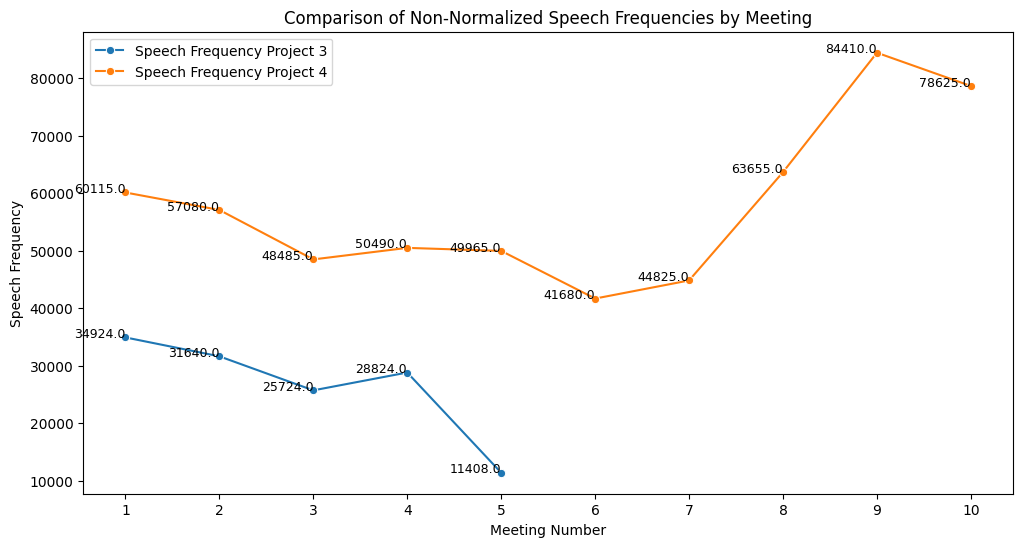

In [535]:
# Compare non-normalized speech frequencies by project
speech_comparison_df = combined_dataset.groupby(['project', 'meeting_number'])['speech_frequency'].sum().reset_index()
speech_comparison_df_pivot = speech_comparison_df.pivot(index='meeting_number', columns='project', values='speech_frequency')
speech_comparison_df_pivot.columns = ['Speech_Frequency_Project3', 'Speech_Frequency_Project4']
speech_comparison_df_pivot.reset_index(inplace=True)

# Filter meeting numbers to include only those with data points for either project
meeting_numbers_with_data = speech_comparison_df_pivot[
    (speech_comparison_df_pivot['Speech_Frequency_Project3'] > 0) |
    (speech_comparison_df_pivot['Speech_Frequency_Project4'] > 0)
]['meeting_number']

plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project3', label='Speech Frequency Project 3', marker='o')
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project4', label='Speech Frequency Project 4', marker='o')
for i in range(len(speech_comparison_df_pivot)):
    if speech_comparison_df_pivot['Speech_Frequency_Project3'].iloc[i] > 0:
        plt.text(speech_comparison_df_pivot['meeting_number'].iloc[i], speech_comparison_df_pivot['Speech_Frequency_Project3'].iloc[i], f'{speech_comparison_df_pivot["Speech_Frequency_Project3"].iloc[i]}', fontsize=9, ha='right')
    if speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(speech_comparison_df_pivot['meeting_number'].iloc[i], speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i], f'{speech_comparison_df_pivot["Speech_Frequency_Project4"].iloc[i]}', fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
plt.xticks(ticks=meeting_numbers_with_data)

plt.title('Comparison of Non-Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend()
plt.show()


## Plot Comparison of Non-Normalized Speech Frequencies by Each Speaker

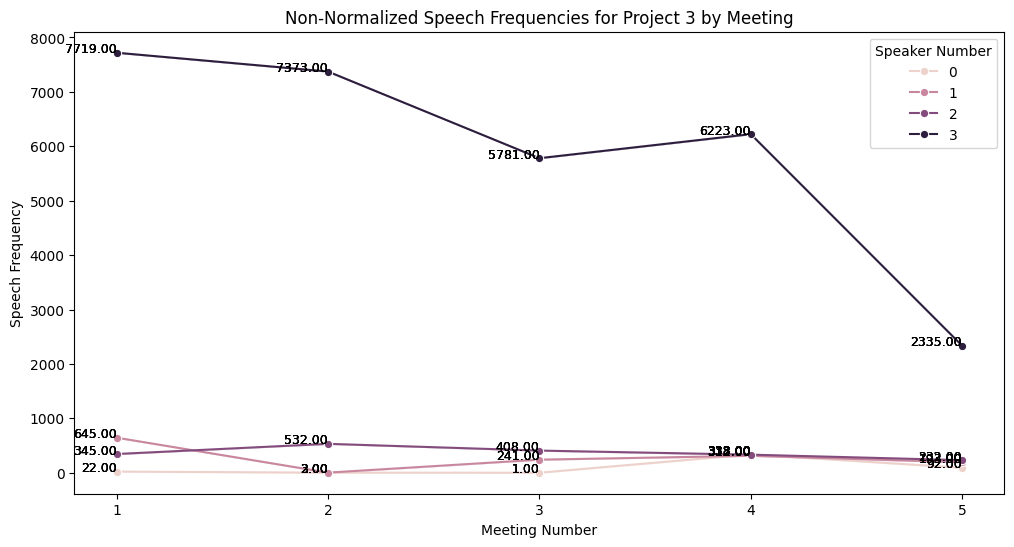

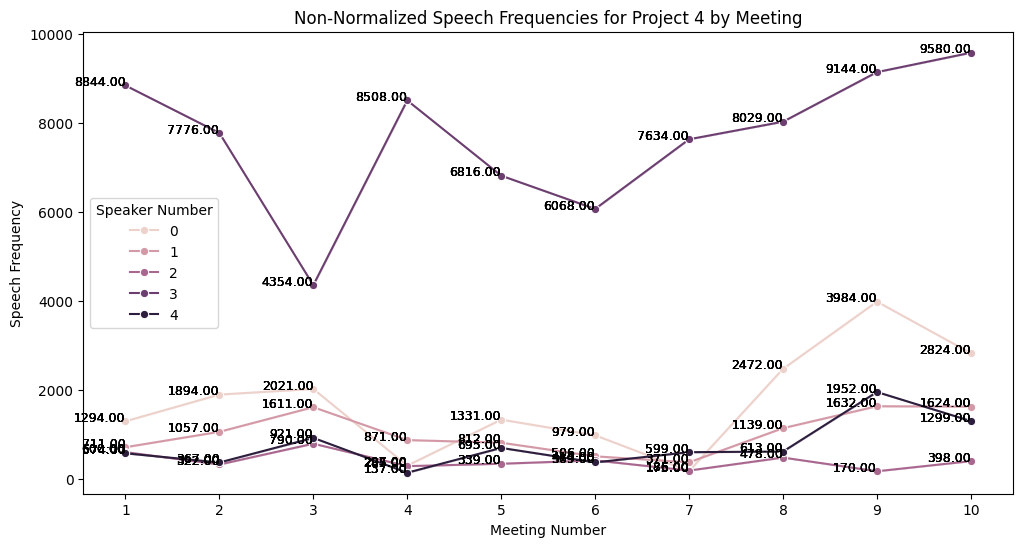

In [536]:
# Plot non-normalized speech frequencies by each speaker for Project 3
plt.figure(figsize=(12, 6))
project_3_data = combined_dataset[combined_dataset['project'] == 3]
sns.lineplot(data=project_3_data, x='meeting_number', y='speech_frequency', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(project_3_data['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for speaker in project_3_data['speaker_number'].unique():
    speaker_data = project_3_data[project_3_data['speaker_number'] == speaker]
    for i in range(len(speaker_data)):
        plt.text(speaker_data['meeting_number'].iloc[i], speaker_data['speech_frequency'].iloc[i], f'{speaker_data["speech_frequency"].iloc[i]:.2f}', fontsize=9, ha='right')
plt.title('Non-Normalized Speech Frequencies for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

# Plot non-normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
project_4_data = combined_dataset[combined_dataset['project'] == 4]
sns.lineplot(data=project_4_data, x='meeting_number', y='speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(project_4_data['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for speaker in project_4_data['speaker_number'].unique():
    speaker_data = project_4_data[project_4_data['speaker_number'] == speaker]
    for i in range(len(speaker_data)):
        plt.text(speaker_data['meeting_number'].iloc[i], speaker_data['speech_frequency'].iloc[i], f'{speaker_data["speech_frequency"].iloc[i]:.2f}', fontsize=9, ha='right')
plt.title('Non-Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Normalized Total Speech Frequencies

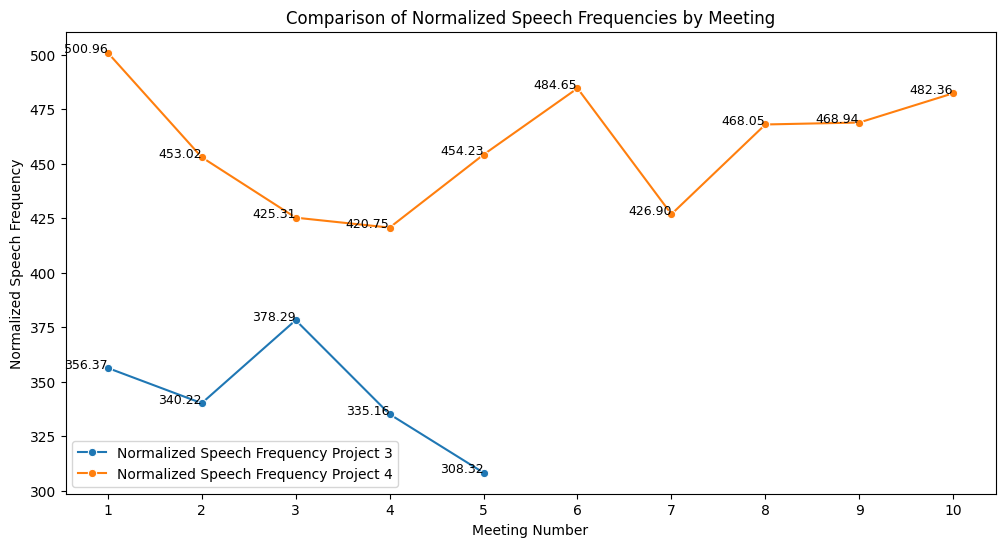

In [537]:
# Compare normalized speech frequencies by project
normalized_speech_comparison_df = combined_dataset.groupby(['project', 'meeting_number'])['normalized_speech_frequency'].sum().reset_index()
normalized_speech_comparison_df_pivot = normalized_speech_comparison_df.pivot(index='meeting_number', columns='project', values='normalized_speech_frequency')
normalized_speech_comparison_df_pivot.columns = ['Normalized_Speech_Frequency_Project3', 'Normalized_Speech_Frequency_Project4']
normalized_speech_comparison_df_pivot.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=normalized_speech_comparison_df_pivot, x='meeting_number', y='Normalized_Speech_Frequency_Project3', label='Normalized Speech Frequency Project 3', marker='o')
sns.lineplot(data=normalized_speech_comparison_df_pivot, x='meeting_number', y='Normalized_Speech_Frequency_Project4', label='Normalized Speech Frequency Project 4', marker='o')
for i in range(len(normalized_speech_comparison_df_pivot)):
    if normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'].iloc[i] > 0:
        plt.text(normalized_speech_comparison_df_pivot['meeting_number'].iloc[i], normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'].iloc[i], f'{normalized_speech_comparison_df_pivot["Normalized_Speech_Frequency_Project3"].iloc[i]:.2f}', fontsize=9, ha='right')
    if normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(normalized_speech_comparison_df_pivot['meeting_number'].iloc[i], normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i], f'{normalized_speech_comparison_df_pivot["Normalized_Speech_Frequency_Project4"].iloc[i]:.2f}', fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = normalized_speech_comparison_df_pivot[(normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'] > 0) | (normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'] > 0)]['meeting_number']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend()
plt.show()


## Plot Comparison of Normalized Speech Frequencies by Each Speaker

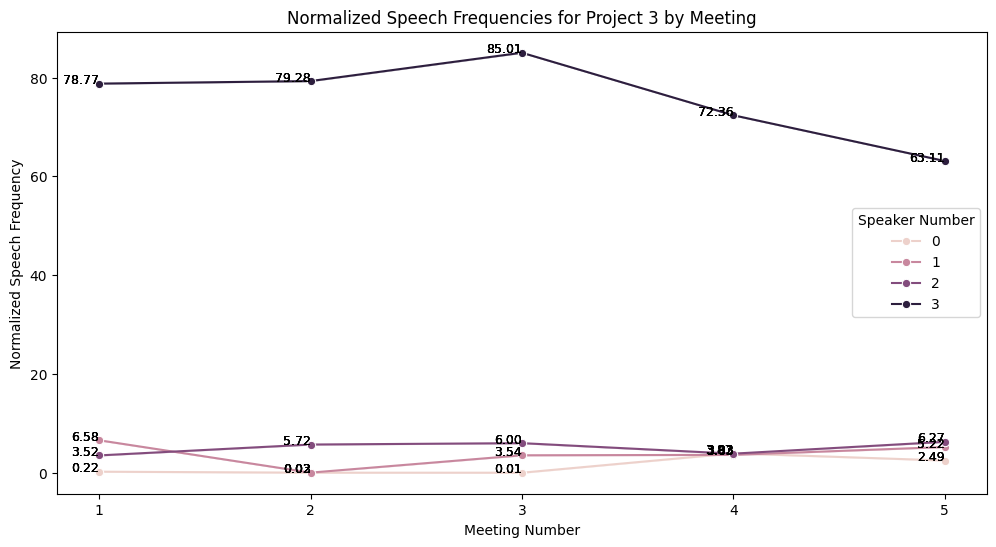

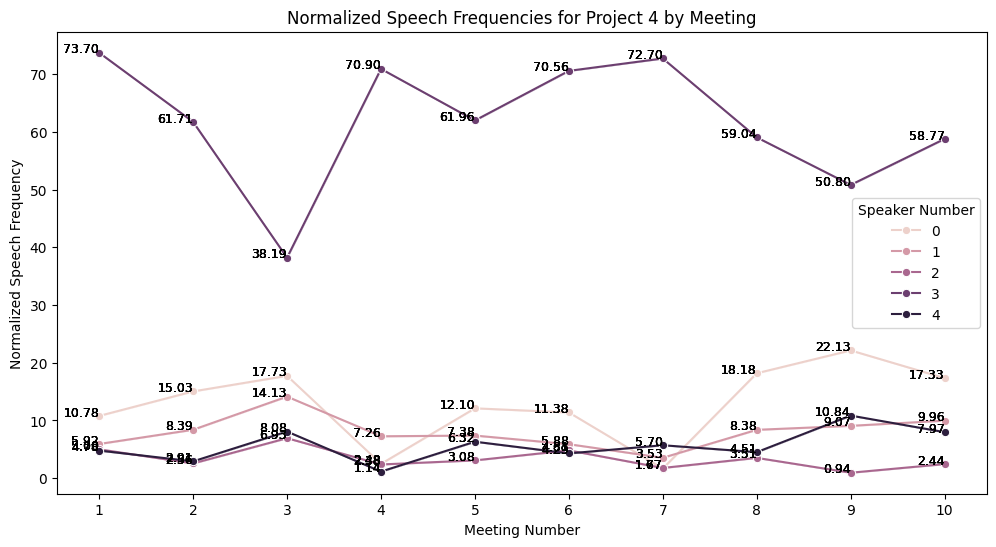

In [538]:
# Plot normalized speech frequencies by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=project_3_data, x='meeting_number', y='normalized_speech_frequency', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(project_3_data['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for speaker in project_3_data['speaker_number'].unique():
    speaker_data = project_3_data[project_3_data['speaker_number'] == speaker]
    for i in range(len(speaker_data)):
        plt.text(speaker_data['meeting_number'].iloc[i], speaker_data['normalized_speech_frequency'].iloc[i], f'{speaker_data["normalized_speech_frequency"].iloc[i]:.2f}', fontsize=9, ha='right')
plt.title('Normalized Speech Frequencies for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

# Plot normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=project_4_data, x='meeting_number', y='normalized_speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(project_4_data['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for speaker in project_4_data['speaker_number'].unique():
    speaker_data = project_4_data[project_4_data['speaker_number'] == speaker]
    for i in range(len(speaker_data)):
        plt.text(speaker_data['meeting_number'].iloc[i], speaker_data['normalized_speech_frequency'].iloc[i], f'{speaker_data["normalized_speech_frequency"].iloc[i]:.2f}', fontsize=9, ha='right')
plt.title('Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Non-Normalized Total Interactions

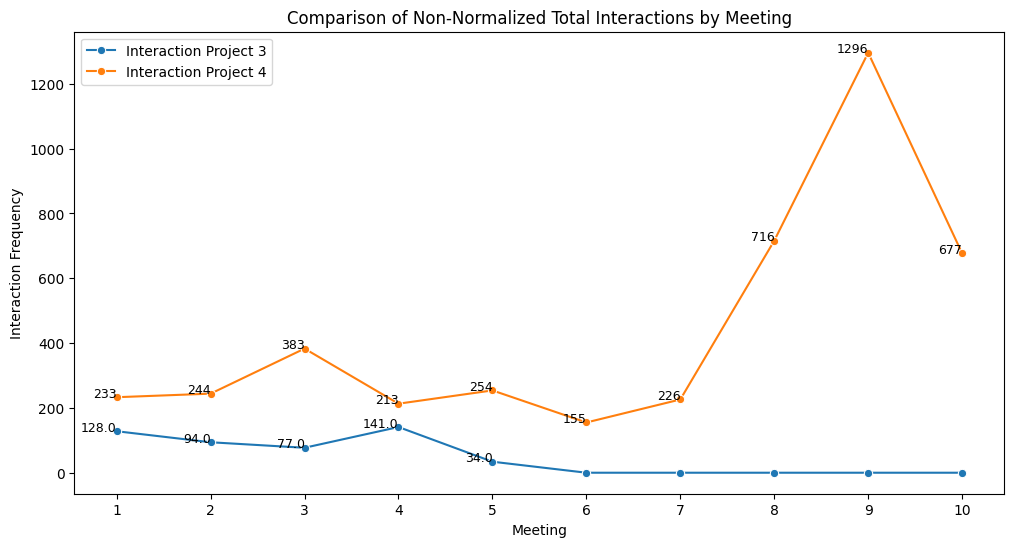

In [539]:
# Compute Interaction Frequencies Excluding Self-Interactions
interaction_frequencies_project3 = combined_dataset[(combined_dataset['project'] == 3) & (combined_dataset['speaker_number'] != combined_dataset['next_speaker_id'])].groupby('meeting_number')['count'].sum().reset_index()
interaction_frequencies_project4 = combined_dataset[(combined_dataset['project'] == 4) & (combined_dataset['speaker_number'] != combined_dataset['next_speaker_id'])].groupby('meeting_number')['count'].sum().reset_index()

# Compare interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1, max(len(interaction_frequencies_project3), len(interaction_frequencies_project4)) + 1),
    'Interaction_Project3': interaction_frequencies_project3.set_index('meeting_number')['count'],
    'Interaction_Project4': interaction_frequencies_project4.set_index('meeting_number')['count']
}).fillna(0).reset_index(drop=True)

# Plot comparison of interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project3', label='Interaction Project 3', marker='o')
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project4', label='Interaction Project 4', marker='o')
for i in range(len(comparison_df)):
    if comparison_df['Interaction_Project3'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Interaction_Project3'].iloc[i], f'{comparison_df["Interaction_Project3"].iloc[i]}', fontsize=9, ha='right')
    if comparison_df['Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Interaction_Project4'].iloc[i], f'{comparison_df["Interaction_Project4"].iloc[i]}', fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(comparison_df['Interaction_Project3'] > 0) | (comparison_df['Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Non-Normalized Total Interactions by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Interaction Frequency')
plt.legend()
plt.show()


## Plot Comparison of Non-Normalized Interactions by Each Speaker

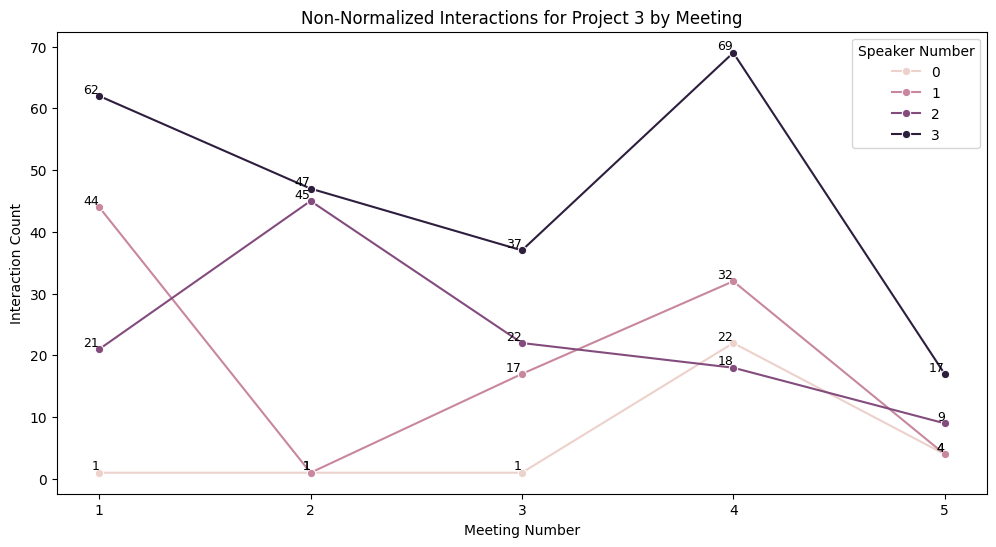

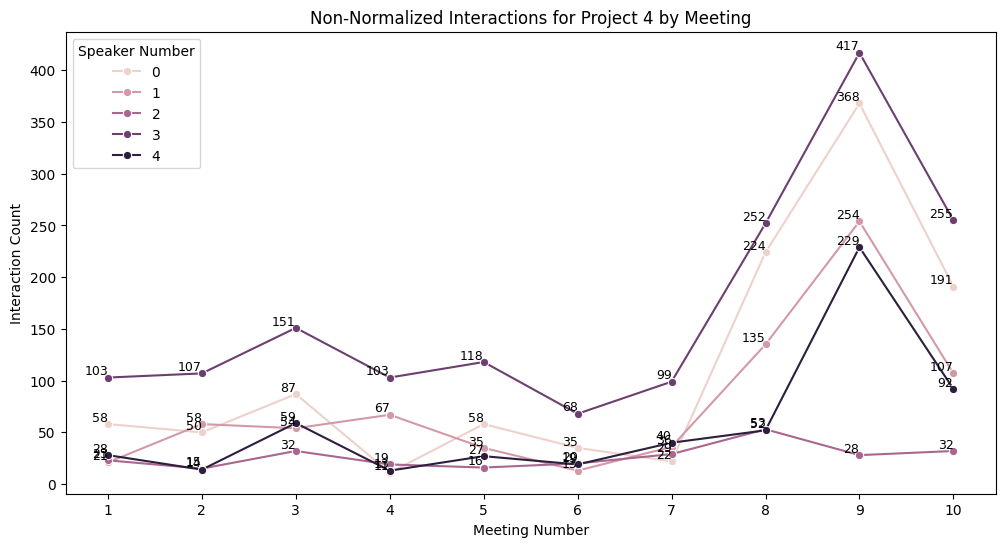

In [540]:
# Exclude self-interactions and summarize interactions for Project 3
summary_project_3 = combined_dataset[(combined_dataset['project'] == 3) & (combined_dataset['speaker_number'] != combined_dataset['next_speaker_id'])].groupby(['meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Plot non-normalized interactions by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_3, x='meeting_number', y='count', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(summary_project_3['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(summary_project_3)):
    plt.text(summary_project_3['meeting_number'].iloc[i], summary_project_3['count'].iloc[i],
             f'{summary_project_3["count"].iloc[i]}', fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Interactions for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

# Exclude self-interactions and summarize interactions for Project 4
summary_project_4 = combined_dataset[(combined_dataset['project'] == 4) & (combined_dataset['speaker_number'] != combined_dataset['next_speaker_id'])].groupby(['meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Plot non-normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_4, x='meeting_number', y='count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(summary_project_4['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(summary_project_4)):
    plt.text(summary_project_4['meeting_number'].iloc[i], summary_project_4['count'].iloc[i],
             f'{summary_project_4["count"].iloc[i]}', fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Interaction Count')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Normalized Total Interactions

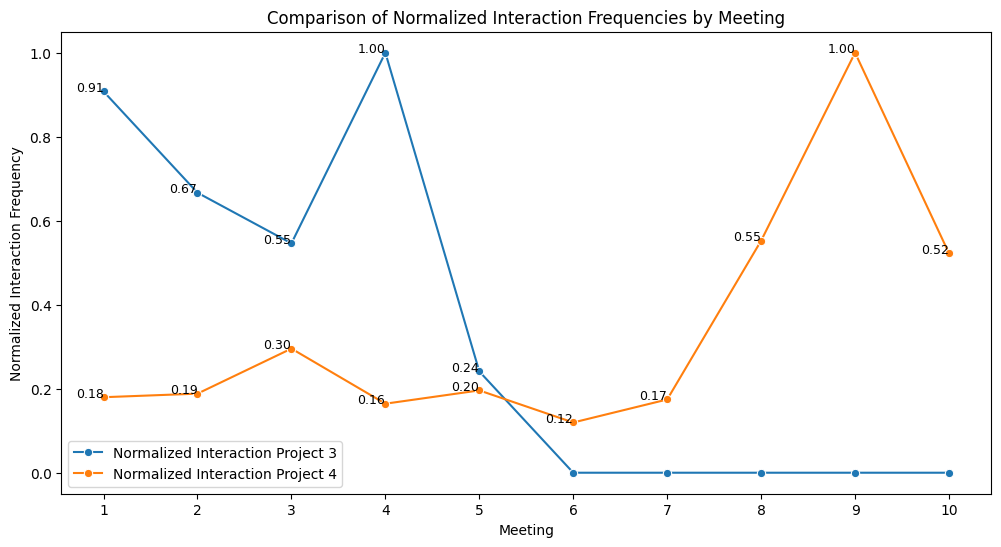

In [541]:
# Normalize interaction frequencies
comparison_df['Normalized_Interaction_Project3'] = comparison_df['Interaction_Project3'] / comparison_df['Interaction_Project3'].max()
comparison_df['Normalized_Interaction_Project4'] = comparison_df['Interaction_Project4'] / comparison_df['Interaction_Project4'].max()

# Plot comparison of normalized interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project3', label='Normalized Interaction Project 3', marker='o')
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project4', label='Normalized Interaction Project 4', marker='o')
for i in range(len(comparison_df)):
    if comparison_df['Normalized_Interaction_Project3'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Normalized_Interaction_Project3'].iloc[i], f'{comparison_df["Normalized_Interaction_Project3"].iloc[i]:.2f}', fontsize=9, ha='right')
    if comparison_df['Normalized_Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Normalized_Interaction_Project4'].iloc[i], f'{comparison_df["Normalized_Interaction_Project4"].iloc[i]:.2f}', fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(comparison_df['Normalized_Interaction_Project3'] > 0) | (comparison_df['Normalized_Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Normalized Interaction Frequencies by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Normalized Interaction Frequency')
plt.legend()
plt.show()


## Plot Comparison of Normalized Interactions by Each Speaker

C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\3023269493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_3_data['normalized_count'] = project_3_data['count'] / project_3_data['duration']


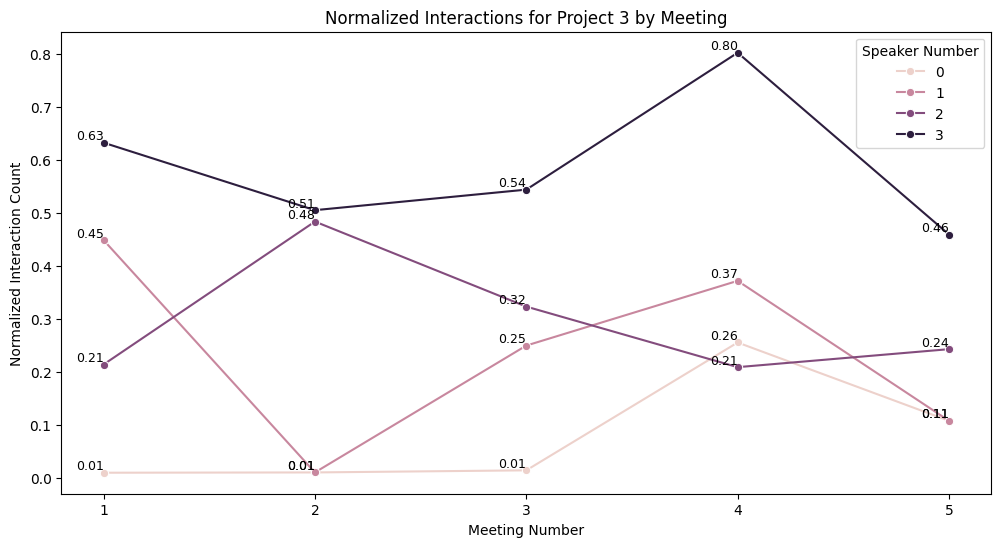

C:\Users\sunti\AppData\Local\Temp\ipykernel_15228\3023269493.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_4_data['normalized_count'] = project_4_data['count'] / project_4_data['duration']


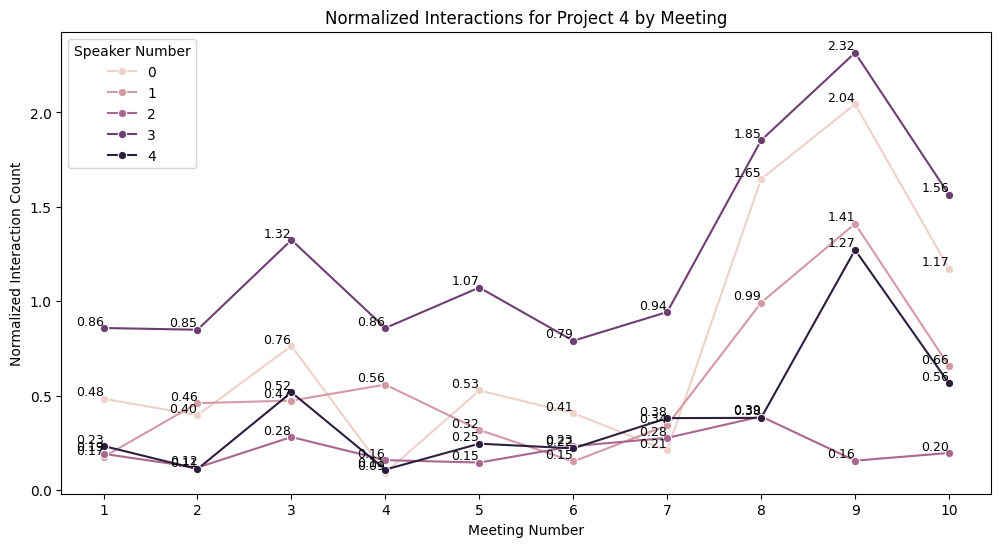

In [542]:
# Normalize interaction frequencies as count / duration for Project 3
project_3_data['normalized_count'] = project_3_data['count'] / project_3_data['duration']

# Exclude self-interactions and summarize normalized interactions for Project 3
summary_project_3 = project_3_data[project_3_data['speaker_number'] != project_3_data['next_speaker_id']].groupby(['meeting_number', 'speaker_number'])['normalized_count'].sum().reset_index()

# Plot normalized interactions by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_3, x='meeting_number', y='normalized_count', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(summary_project_3['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(summary_project_3)):
    plt.text(summary_project_3['meeting_number'].iloc[i], summary_project_3['normalized_count'].iloc[i],
             f'{summary_project_3["normalized_count"].iloc[i]:.2f}', fontsize=9, ha='right', va='bottom')
plt.title('Normalized Interactions for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

# Normalize interaction frequencies as count / duration for Project 4
project_4_data['normalized_count'] = project_4_data['count'] / project_4_data['duration']

# Exclude self-interactions and summarize normalized interactions for Project 4
summary_project_4 = project_4_data[project_4_data['speaker_number'] != project_4_data['next_speaker_id']].groupby(['meeting_number', 'speaker_number'])['normalized_count'].sum().reset_index()

# Plot normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_4, x='meeting_number', y='normalized_count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(summary_project_4['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(summary_project_4)):
    plt.text(summary_project_4['meeting_number'].iloc[i], summary_project_4['normalized_count'].iloc[i],
             f'{summary_project_4["normalized_count"].iloc[i]:.2f}', fontsize=9, ha='right', va='bottom')
plt.title('Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Interaction Count')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Network Densities

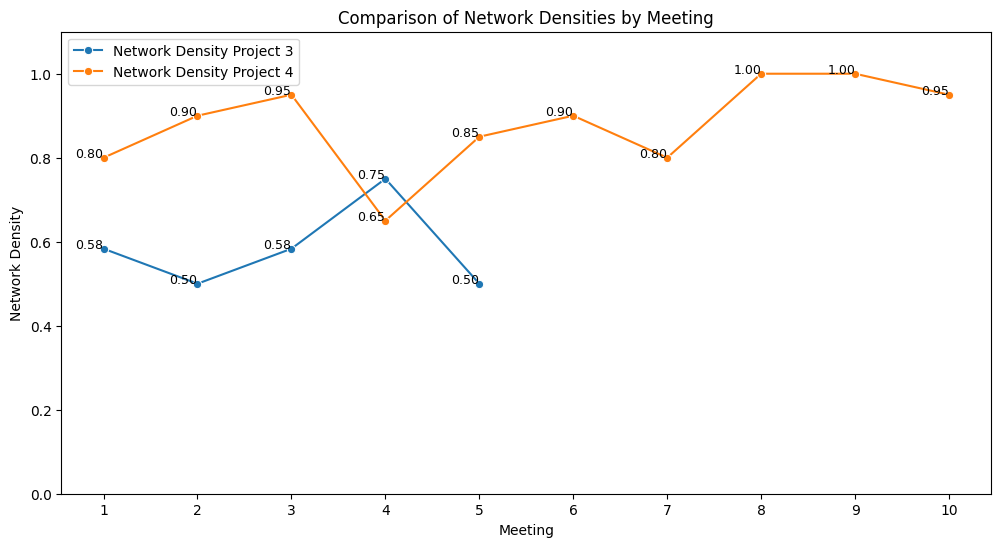

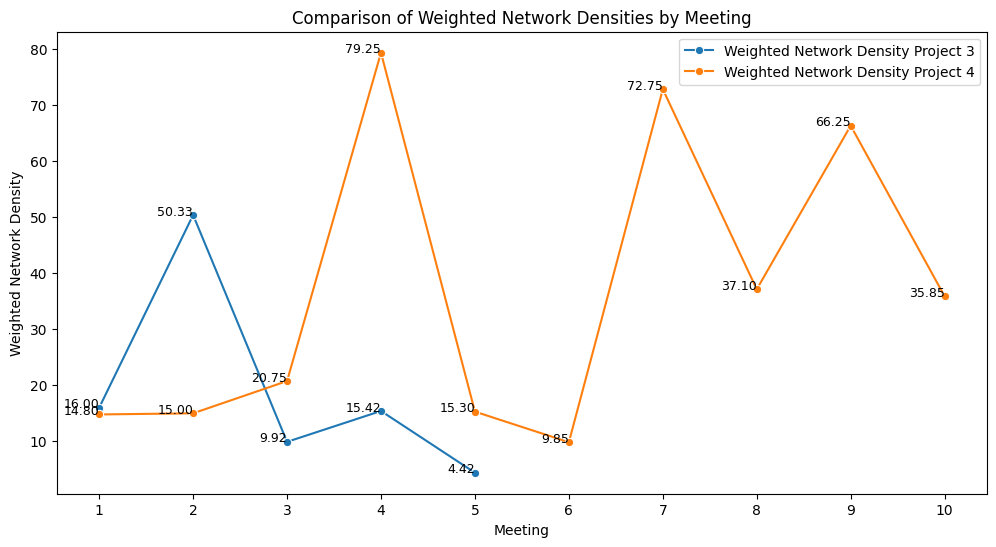

In [543]:
# Plot comparison of network densities
plt.figure(figsize=(12, 6))
df_project3 = pd.DataFrame({'Meeting': range(1, len(densities_project3) + 1), 'Network Density': densities_project3})
df_project4 = pd.DataFrame({'Meeting': range(1, len(densities_project4) + 1), 'Network Density': densities_project4})

sns.lineplot(data=df_project3, x='Meeting', y='Network Density', label='Network Density Project 3', marker='o')
sns.lineplot(data=df_project4, x='Meeting', y='Network Density', label='Network Density Project 4', marker='o')

for i in range(len(df_project3)):
    if df_project3['Network Density'].iloc[i] > 0:
        plt.text(df_project3['Meeting'].iloc[i], df_project3['Network Density'].iloc[i], f'{df_project3["Network Density"].iloc[i]:.2f}', fontsize=9, ha='right')
for i in range(len(df_project4)):
    if df_project4['Network Density'].iloc[i] > 0:
        plt.text(df_project4['Meeting'].iloc[i], df_project4['Network Density'].iloc[i], f'{df_project4["Network Density"].iloc[i]:.2f}', fontsize=9, ha='right')

plt.ylim(0, 1.1)
plt.xticks(ticks=range(1, max(len(df_project3), len(df_project4)) + 1))
plt.title('Comparison of Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Network Density')
plt.legend()
plt.show()

# Plot comparison of weighted network densities
plt.figure(figsize=(12, 6))
df_weighted_project3 = pd.DataFrame({'Meeting': range(1, len(weighted_densities_project3) + 1), 'Weighted Network Density': weighted_densities_project3})
df_weighted_project4 = pd.DataFrame({'Meeting': range(1, len(weighted_densities_project4) + 1), 'Weighted Network Density': weighted_densities_project4})

sns.lineplot(data=df_weighted_project3, x='Meeting', y='Weighted Network Density', label='Weighted Network Density Project 3', marker='o')
sns.lineplot(data=df_weighted_project4, x='Meeting', y='Weighted Network Density', label='Weighted Network Density Project 4', marker='o')

for i in range(len(df_weighted_project3)):
    if df_weighted_project3['Weighted Network Density'].iloc[i] > 0:
        plt.text(df_weighted_project3['Meeting'].iloc[i], df_weighted_project3['Weighted Network Density'].iloc[i], f'{df_weighted_project3["Weighted Network Density"].iloc[i]:.2f}', fontsize=9, ha='right')
for i in range(len(df_weighted_project4)):
    if df_weighted_project4['Weighted Network Density'].iloc[i] > 0:
        plt.text(df_weighted_project4['Meeting'].iloc[i], df_weighted_project4['Weighted Network Density'].iloc[i], f'{df_weighted_project4["Weighted Network Density"].iloc[i]:.2f}', fontsize=9, ha='right')

plt.xticks(ticks=range(1, max(len(df_weighted_project3), len(df_weighted_project4)) + 1))
plt.title('Comparison of Weighted Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Weighted Network Density')
plt.legend()
plt.show()


## Plot Comparison of Centralities

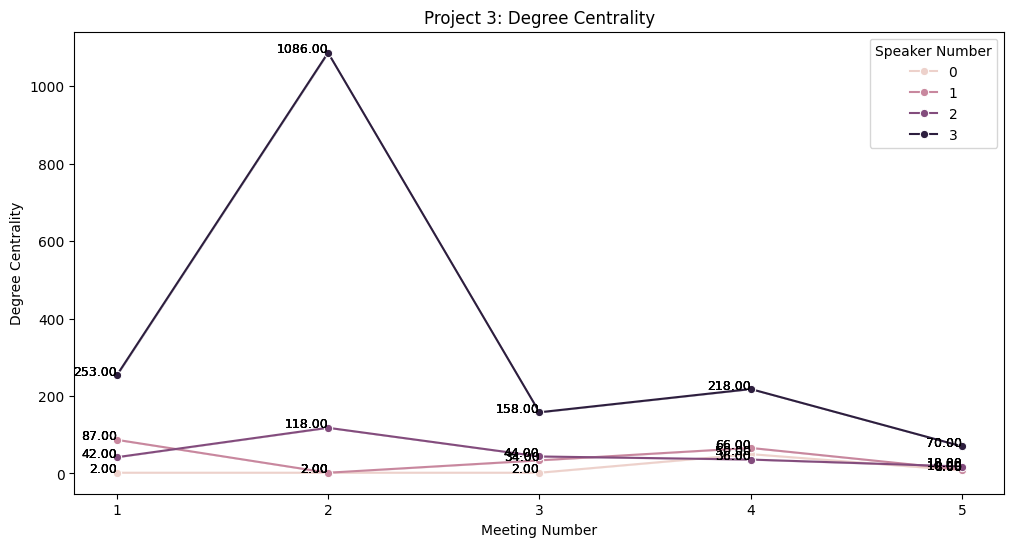

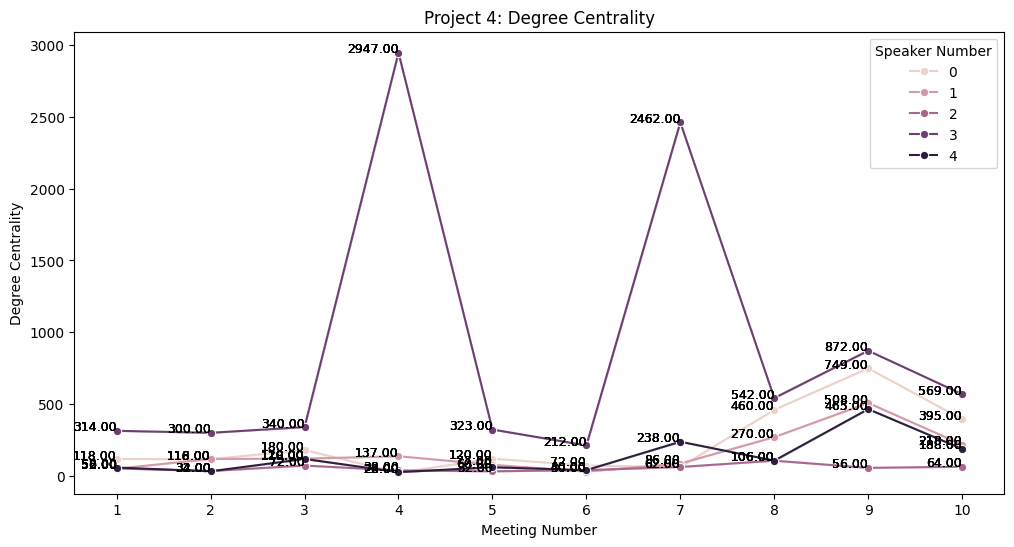

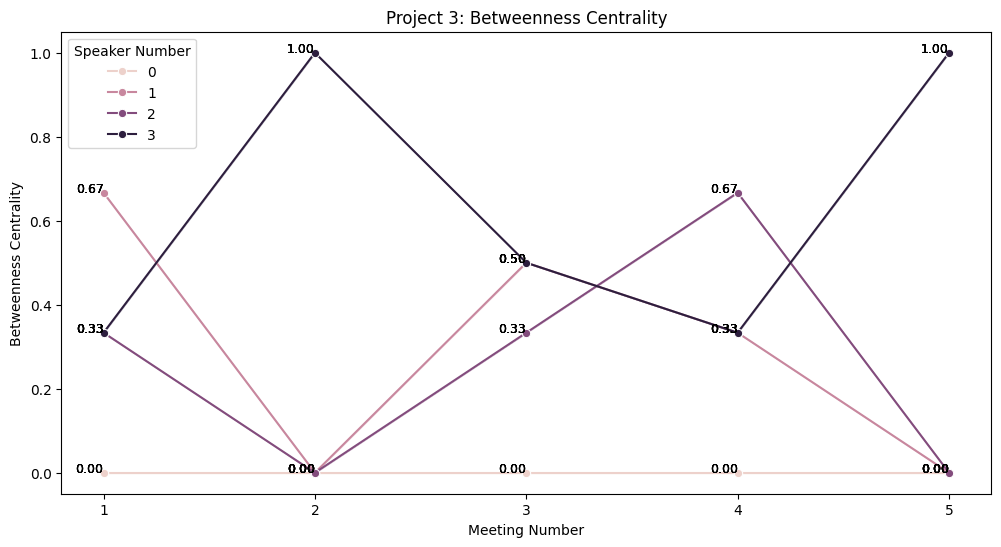

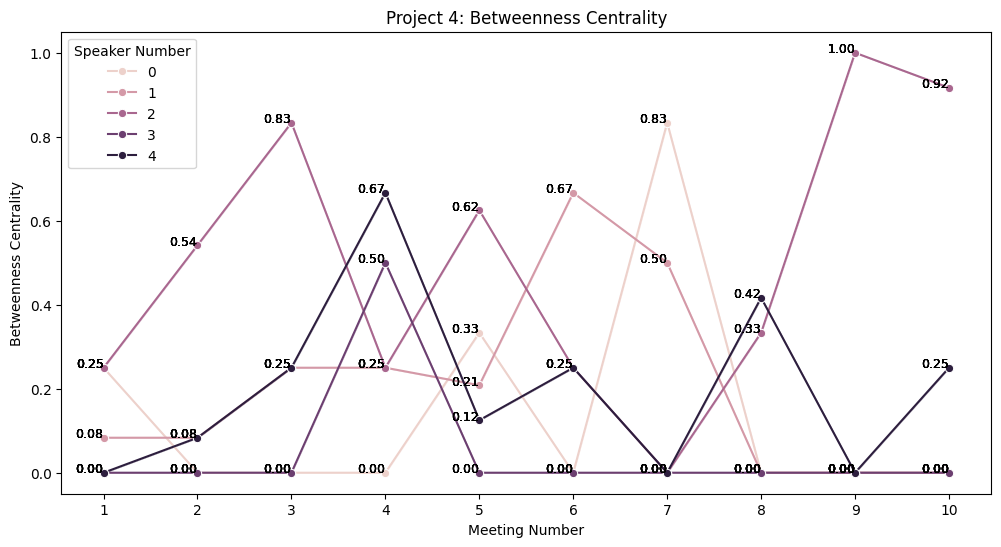

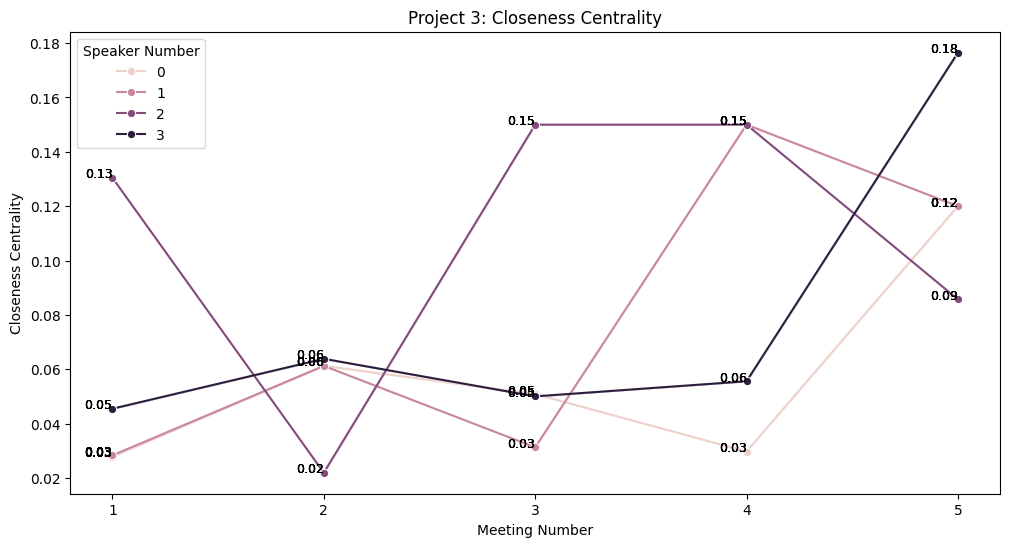

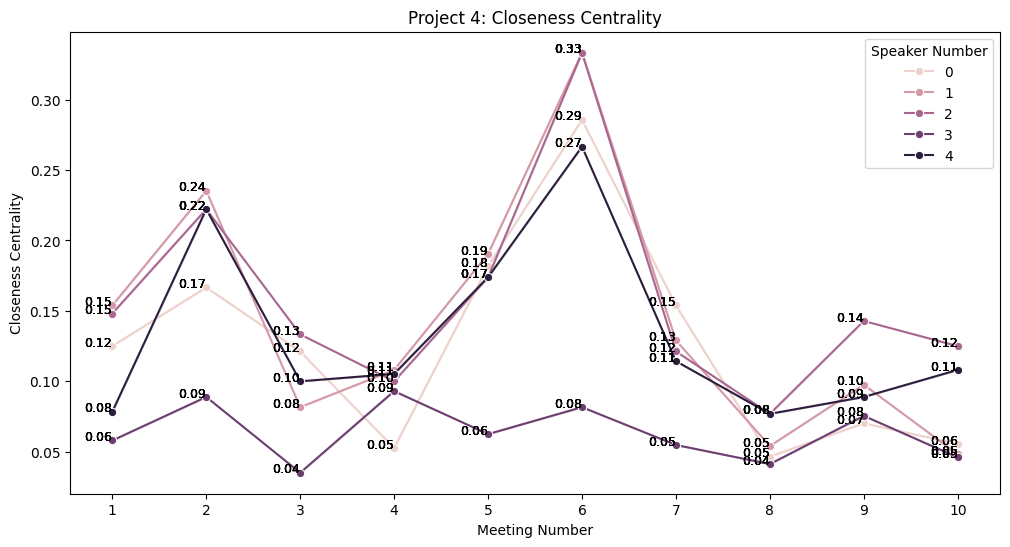

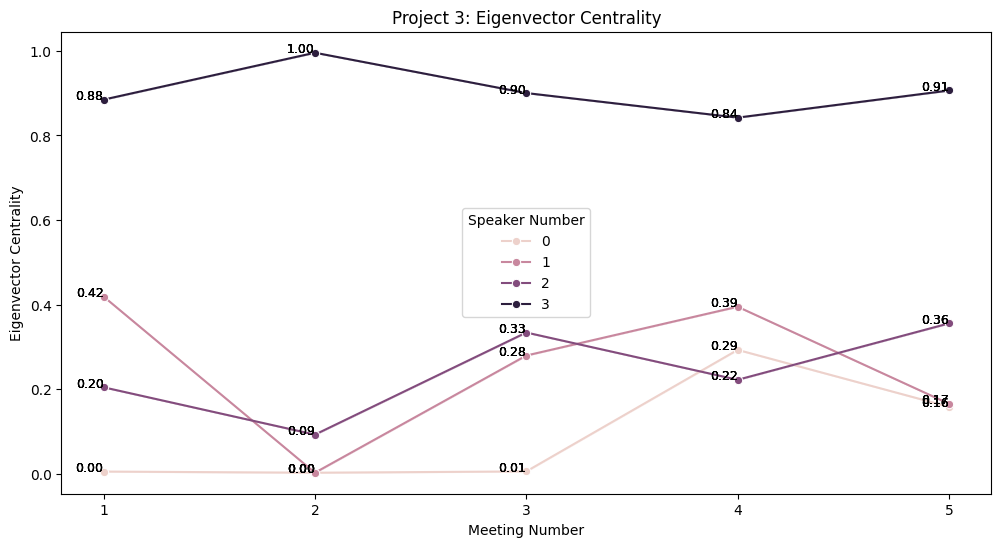

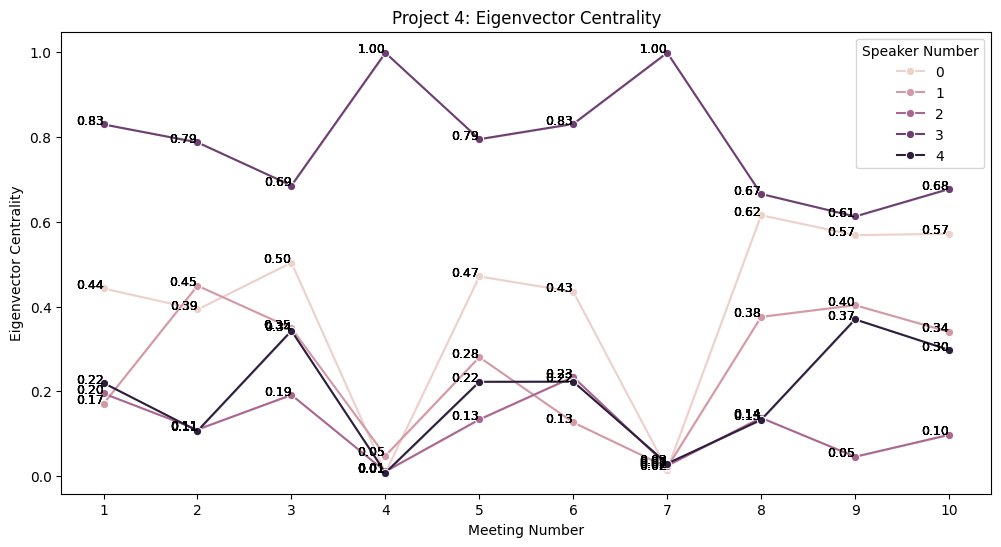

In [544]:
# Define function to plot centrality measures by speaker
def plot_centrality_measures_by_speaker(dataset, measure, title):
    plt.figure(figsize=(12, 6))
    project_3_data = dataset[dataset['project'] == 3]
    sns.lineplot(data=project_3_data, x='meeting_number', y=measure, hue='speaker_number', marker='o', legend='full')
    for speaker in project_3_data['speaker_number'].unique():
        speaker_data = project_3_data[project_3_data['speaker_number'] == speaker]
        for i in range(len(speaker_data)):
            plt.text(speaker_data['meeting_number'].iloc[i], speaker_data[measure].iloc[i], f'{speaker_data[measure].iloc[i]:.2f}', fontsize=9, ha='right')
    plt.xticks(ticks=project_3_data['meeting_number'].unique())
    plt.title(f'Project 3: {title}')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend(title='Speaker Number')
    plt.show()

    plt.figure(figsize=(12, 6))
    project_4_data = dataset[dataset['project'] == 4]
    sns.lineplot(data=project_4_data, x='meeting_number', y=measure, hue='speaker_number', marker='o', legend='full')
    for speaker in project_4_data['speaker_number'].unique():
        speaker_data = project_4_data[project_4_data['speaker_number'] == speaker]
        for i in range(len(speaker_data)):
            plt.text(speaker_data['meeting_number'].iloc[i], speaker_data[measure].iloc[i], f'{speaker_data[measure].iloc[i]:.2f}', fontsize=9, ha='right')
    plt.xticks(ticks=project_4_data['meeting_number'].unique())
    plt.title(f'Project 4: {title}')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend(title='Speaker Number')
    plt.show()

# Plot comparison of centralities by speaker
centrality_measures = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

for measure, title in zip(centrality_measures, titles):
    plot_centrality_measures_by_speaker(combined_dataset, measure, title)

## Plot Interaction Network Graph

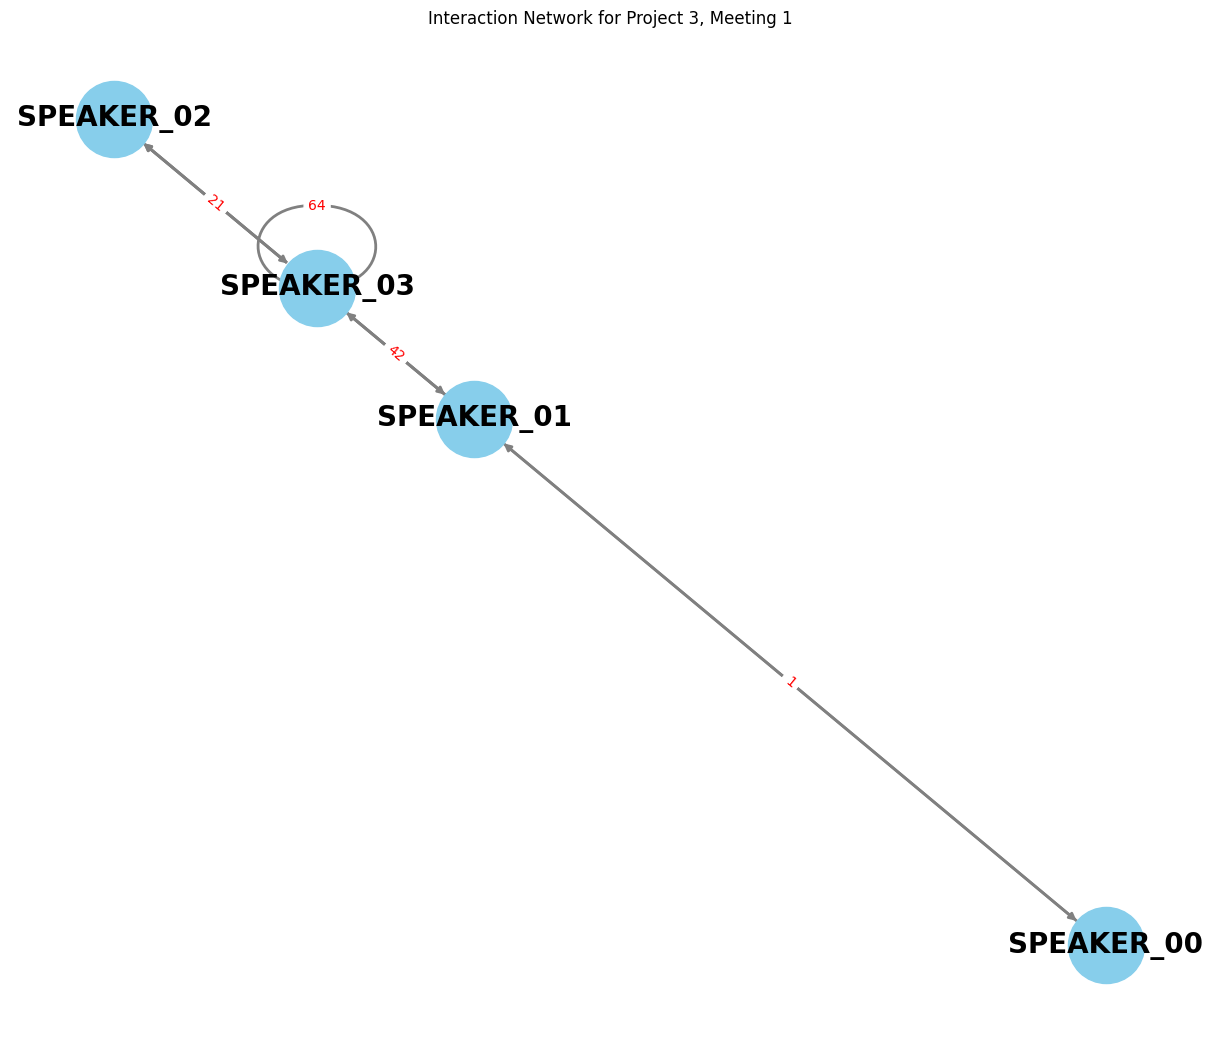

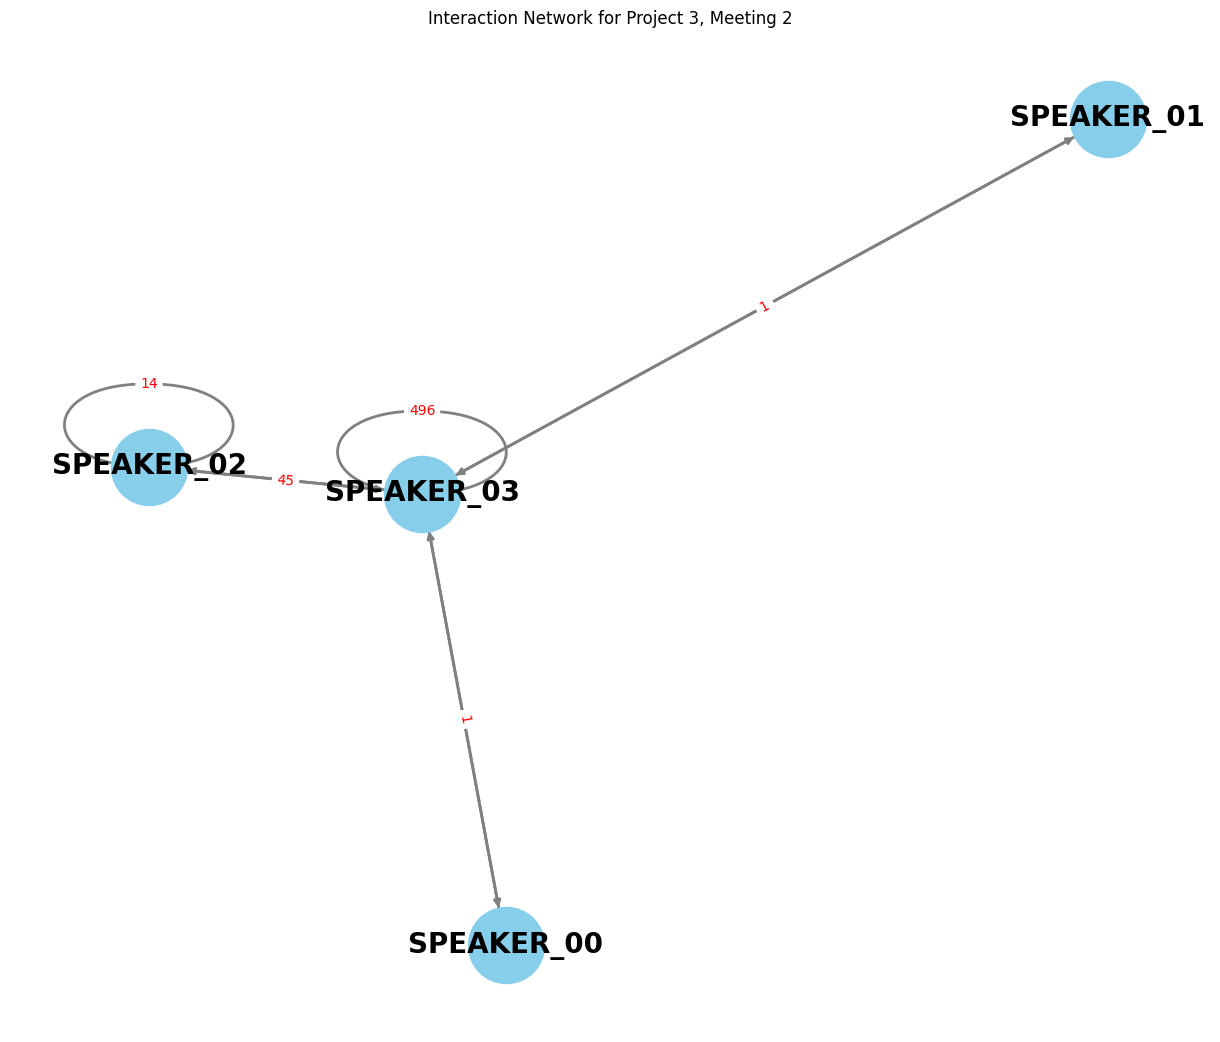

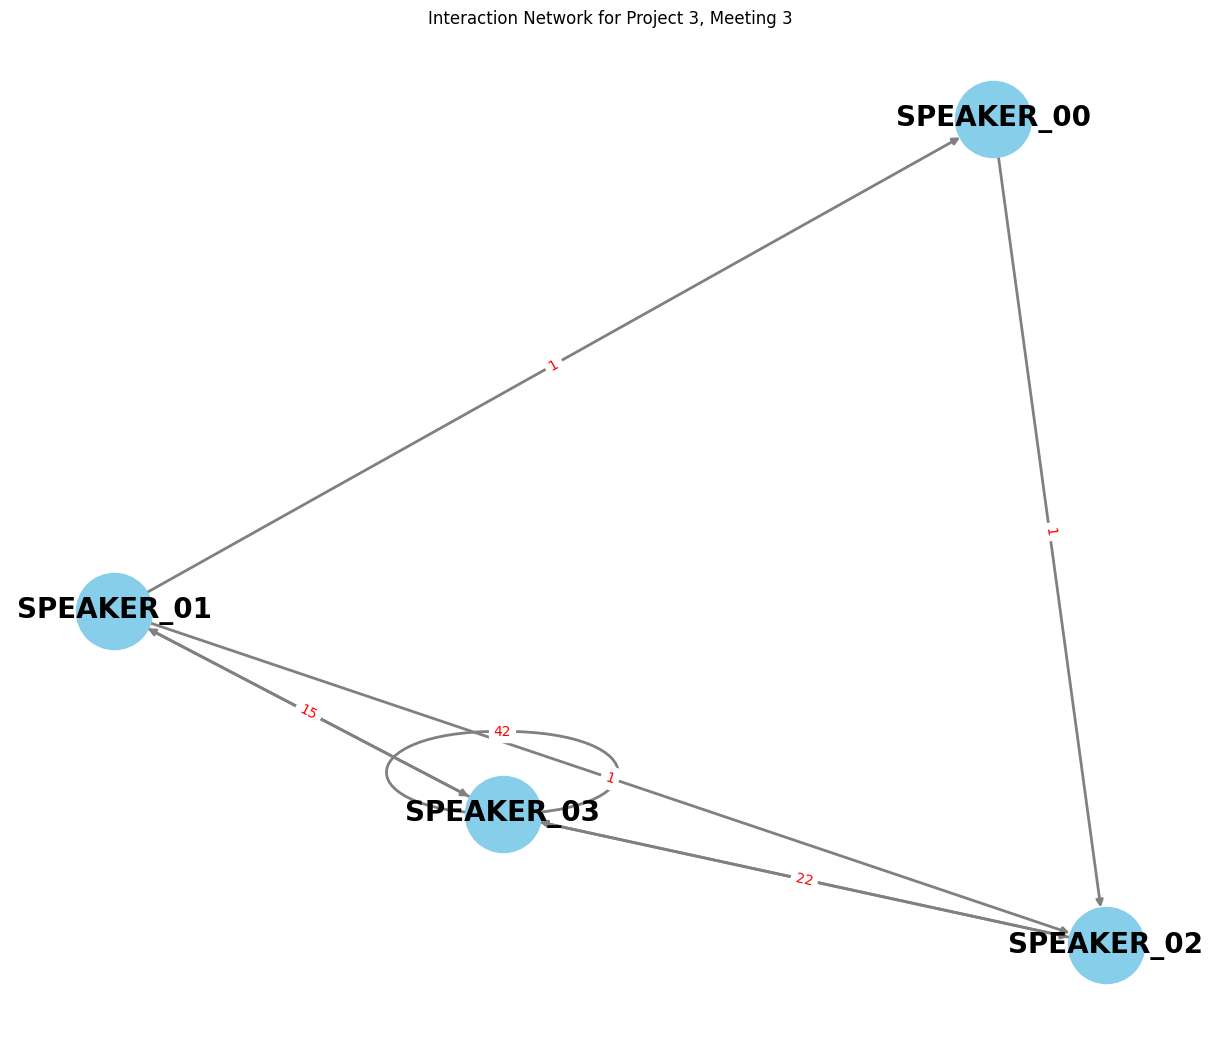

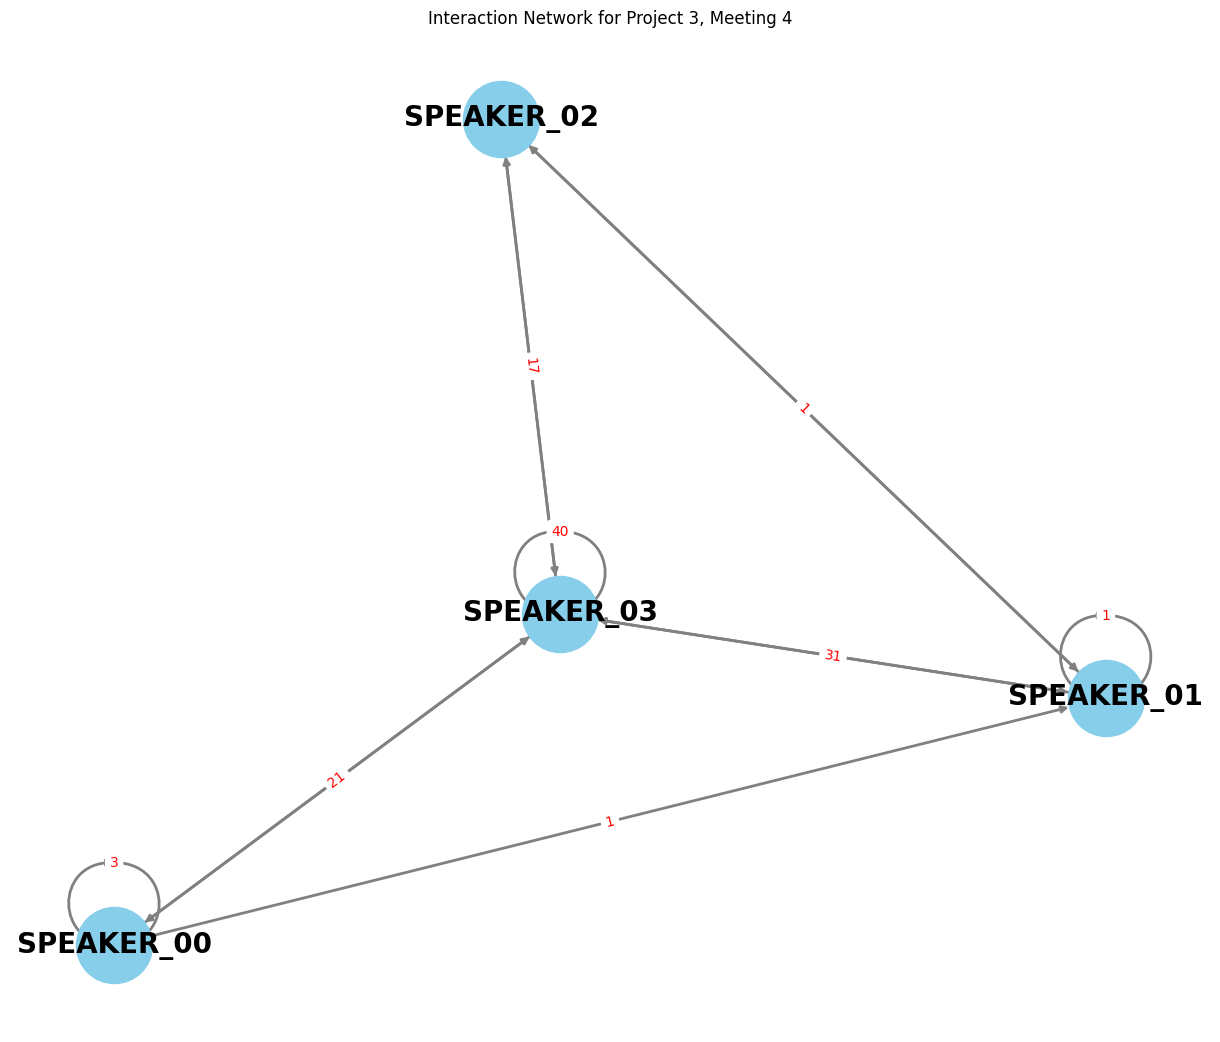

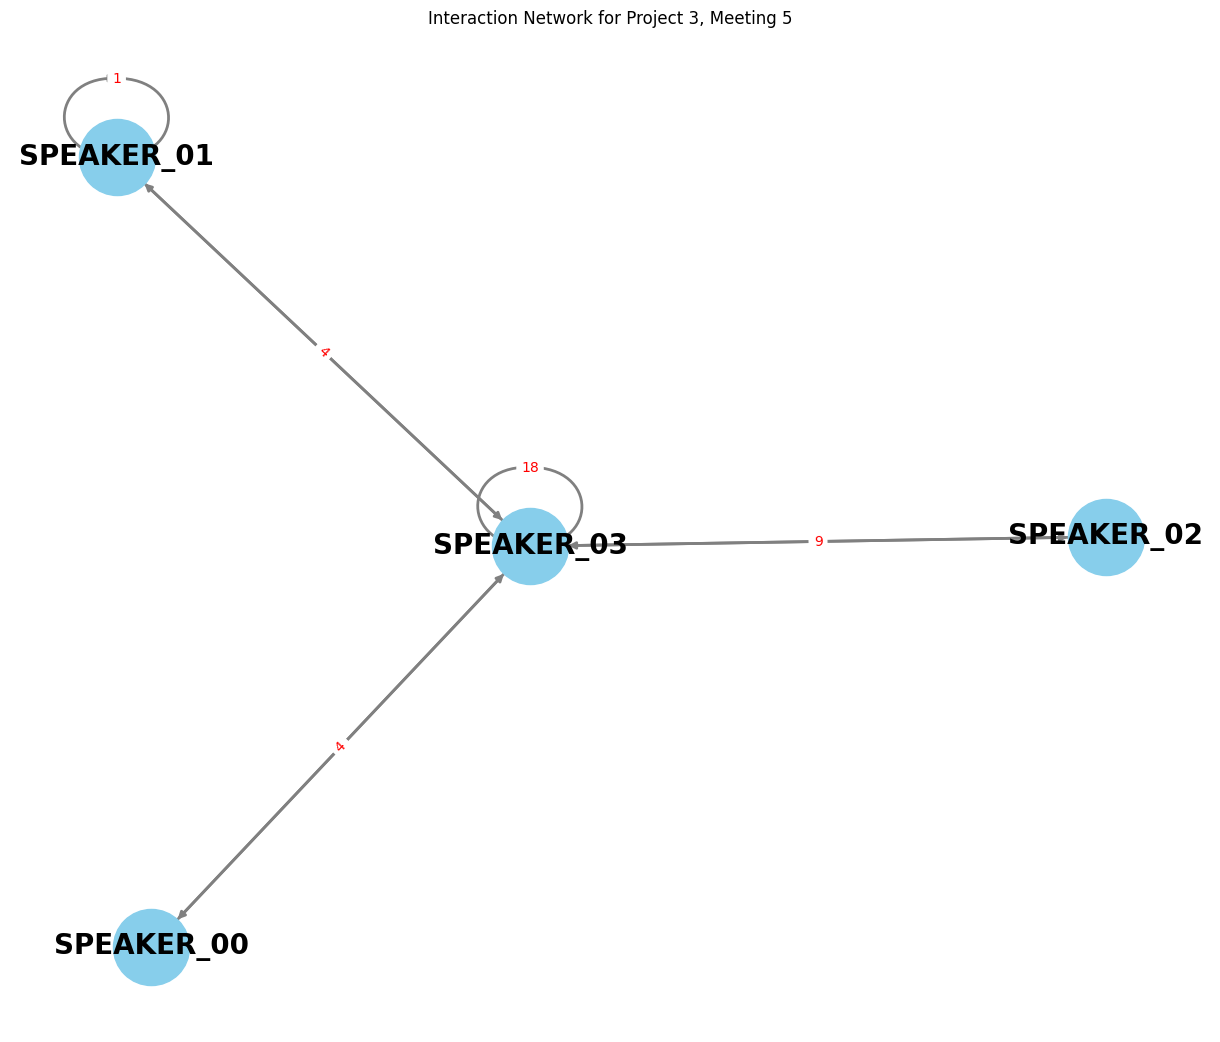

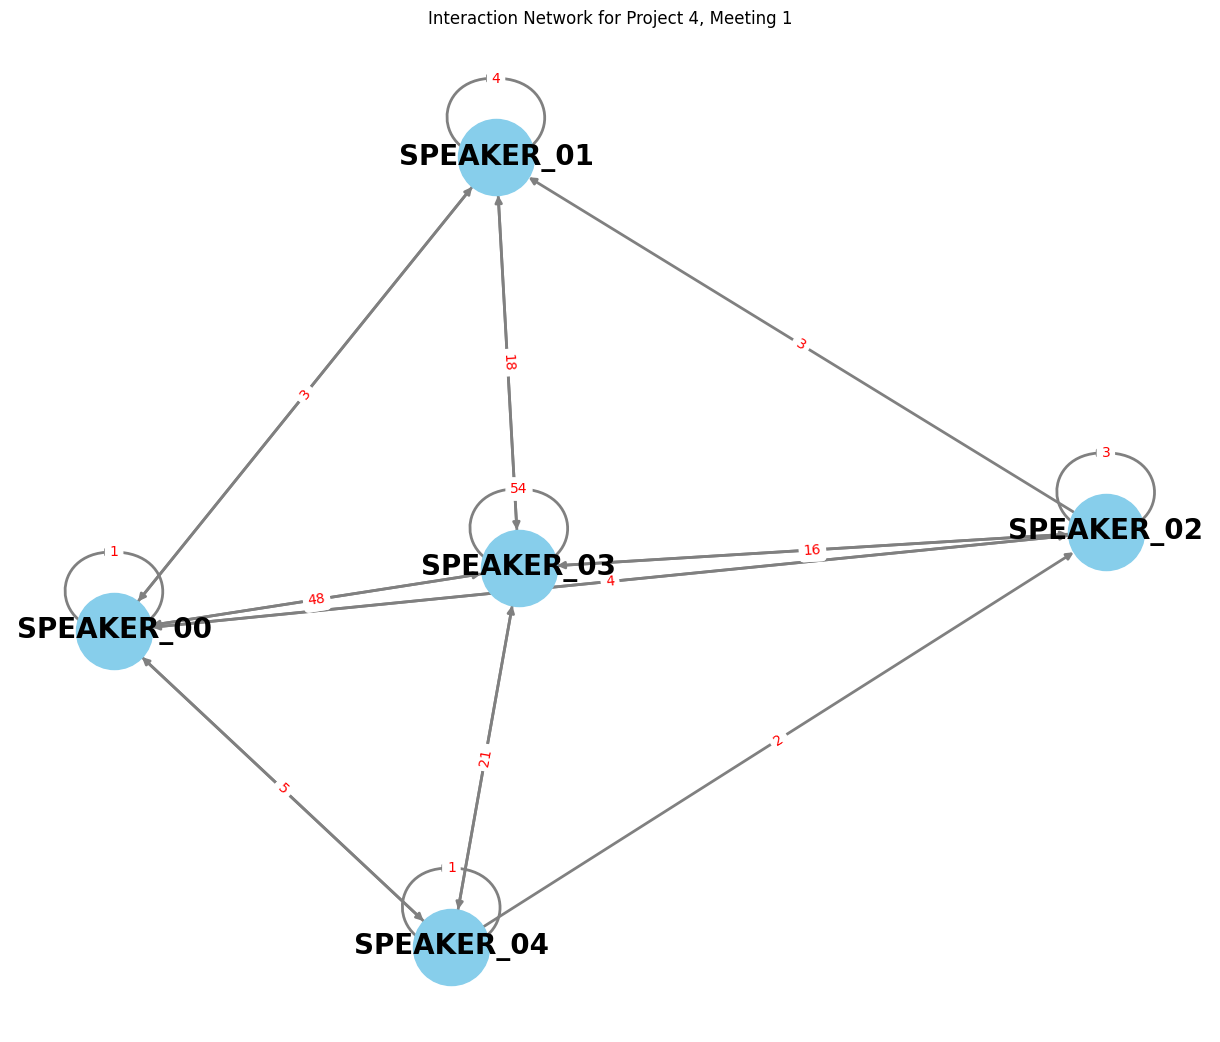

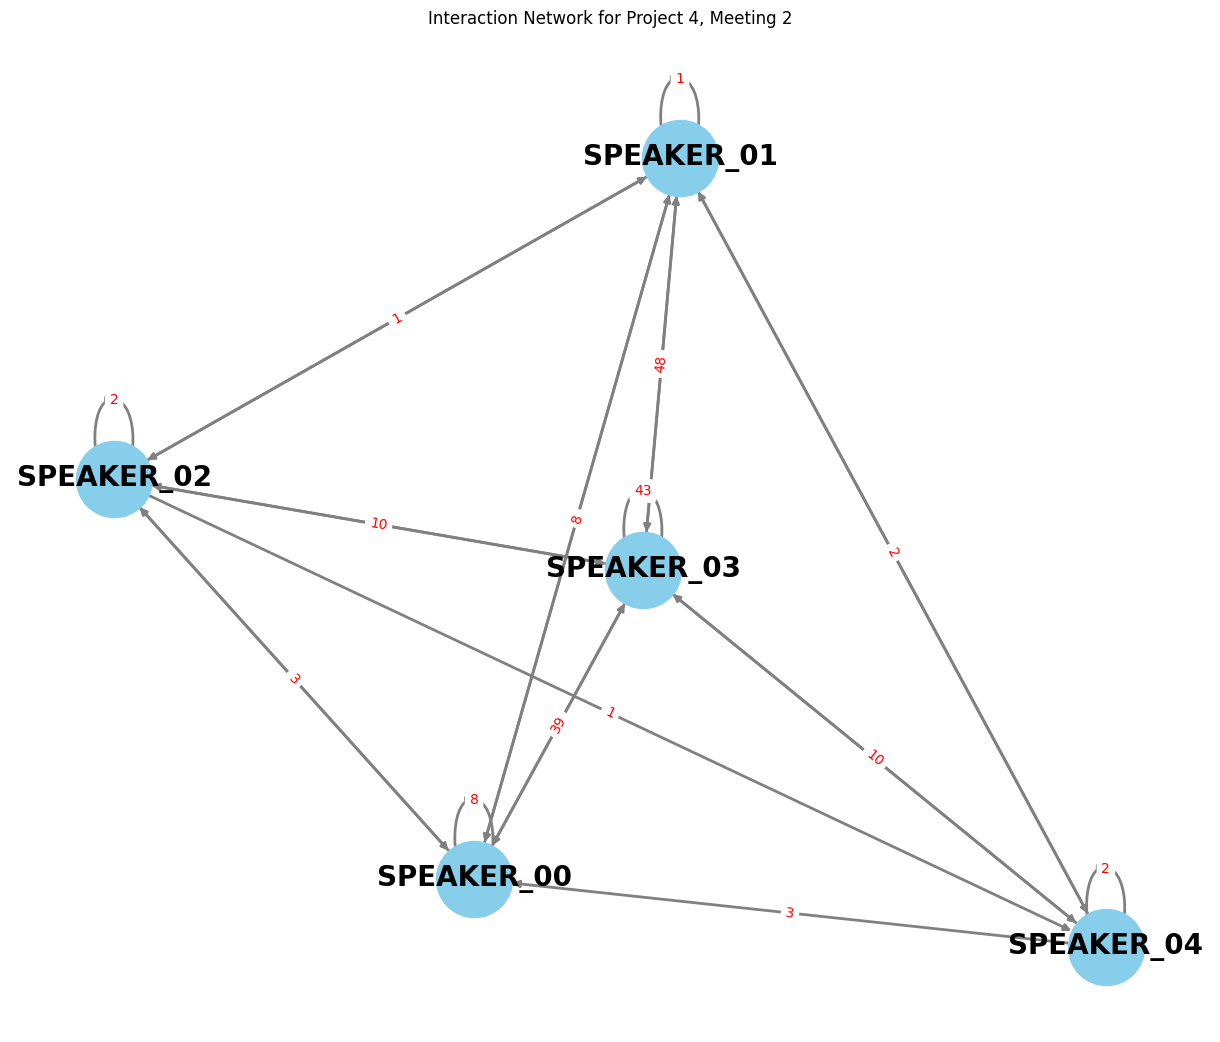

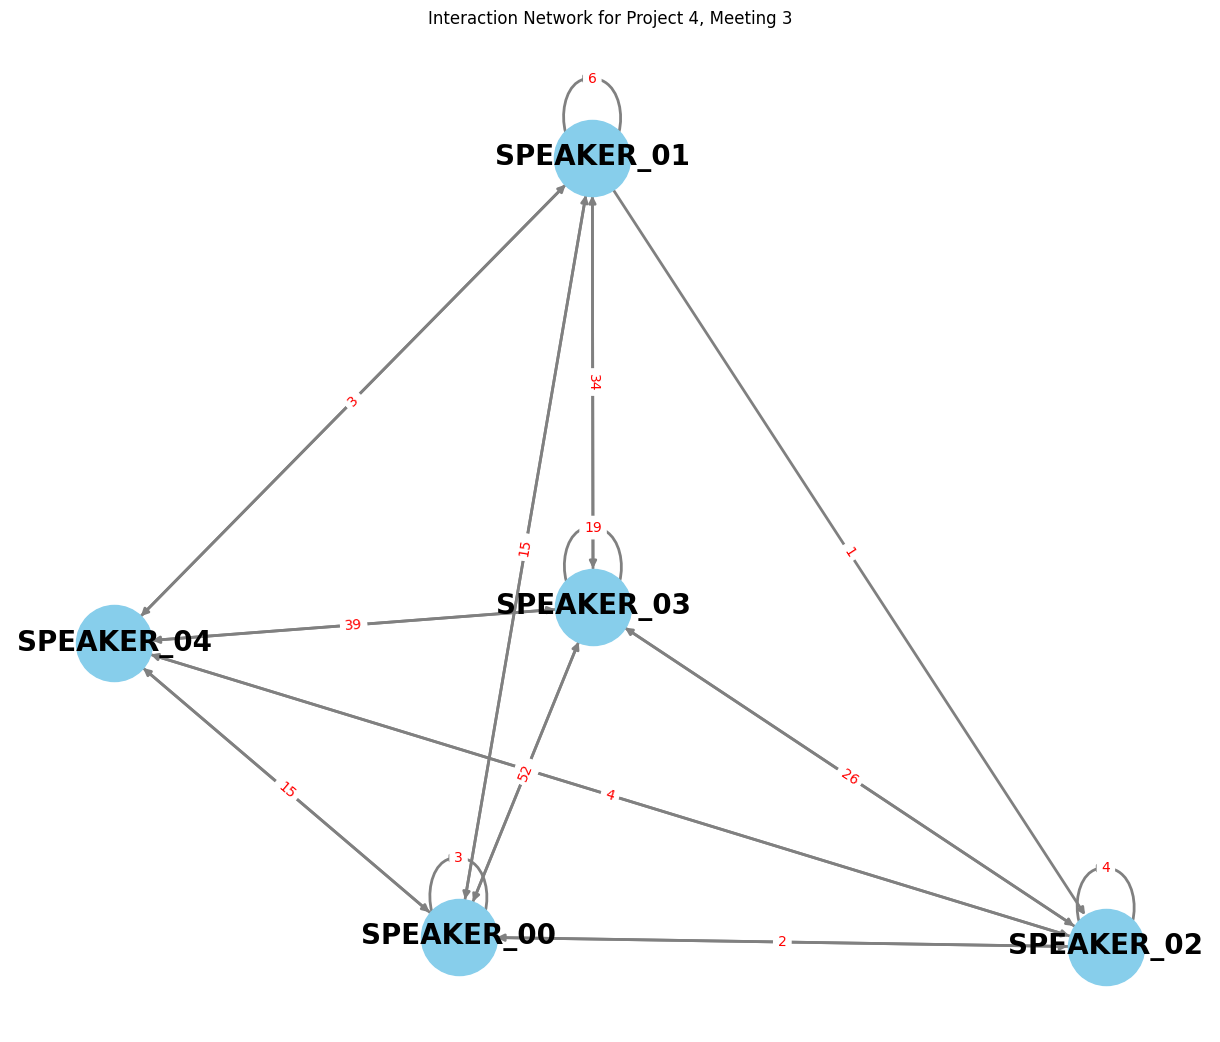

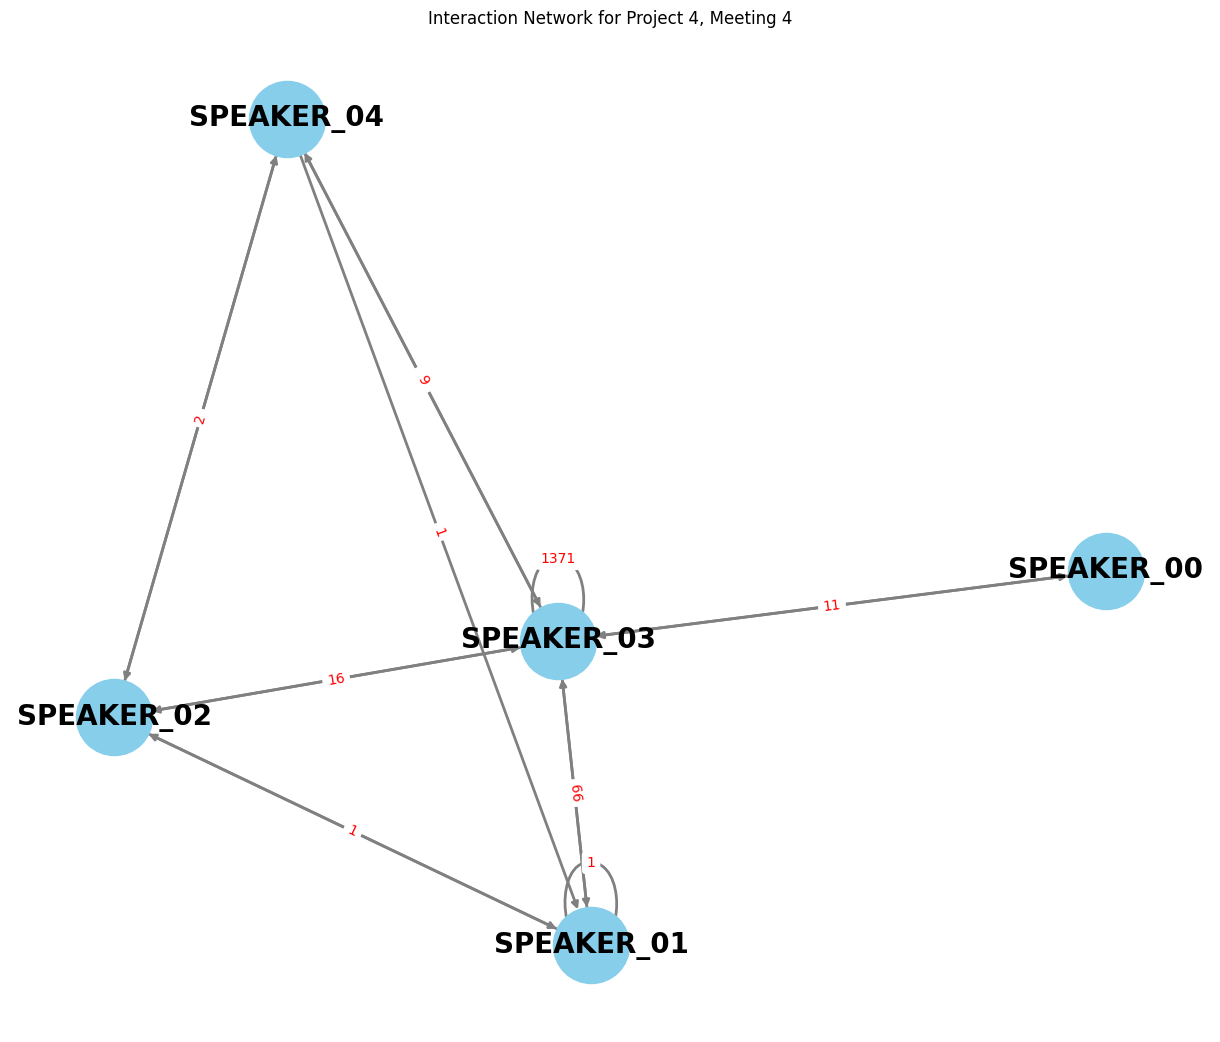

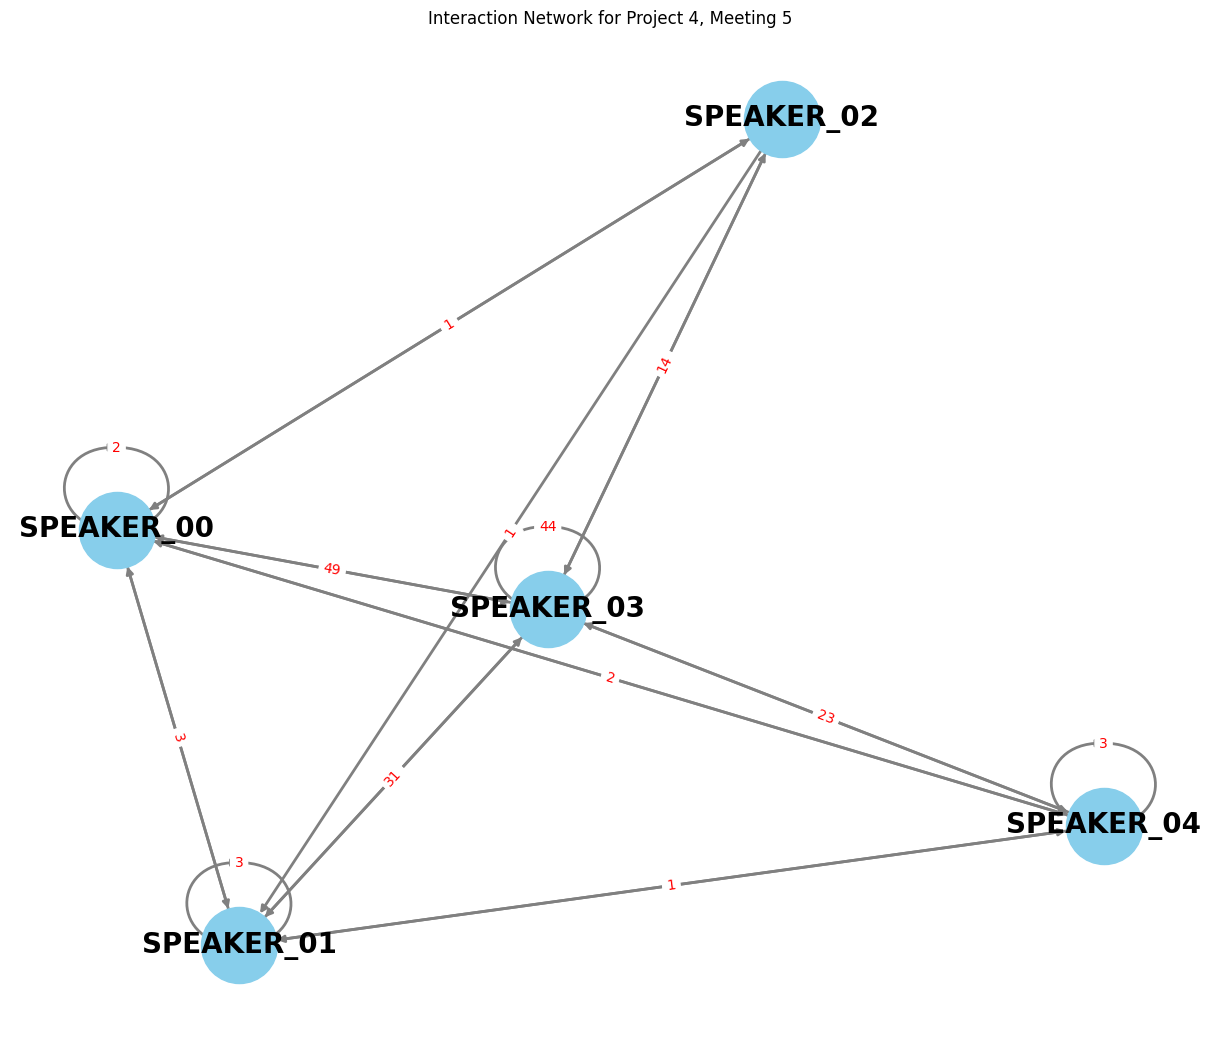

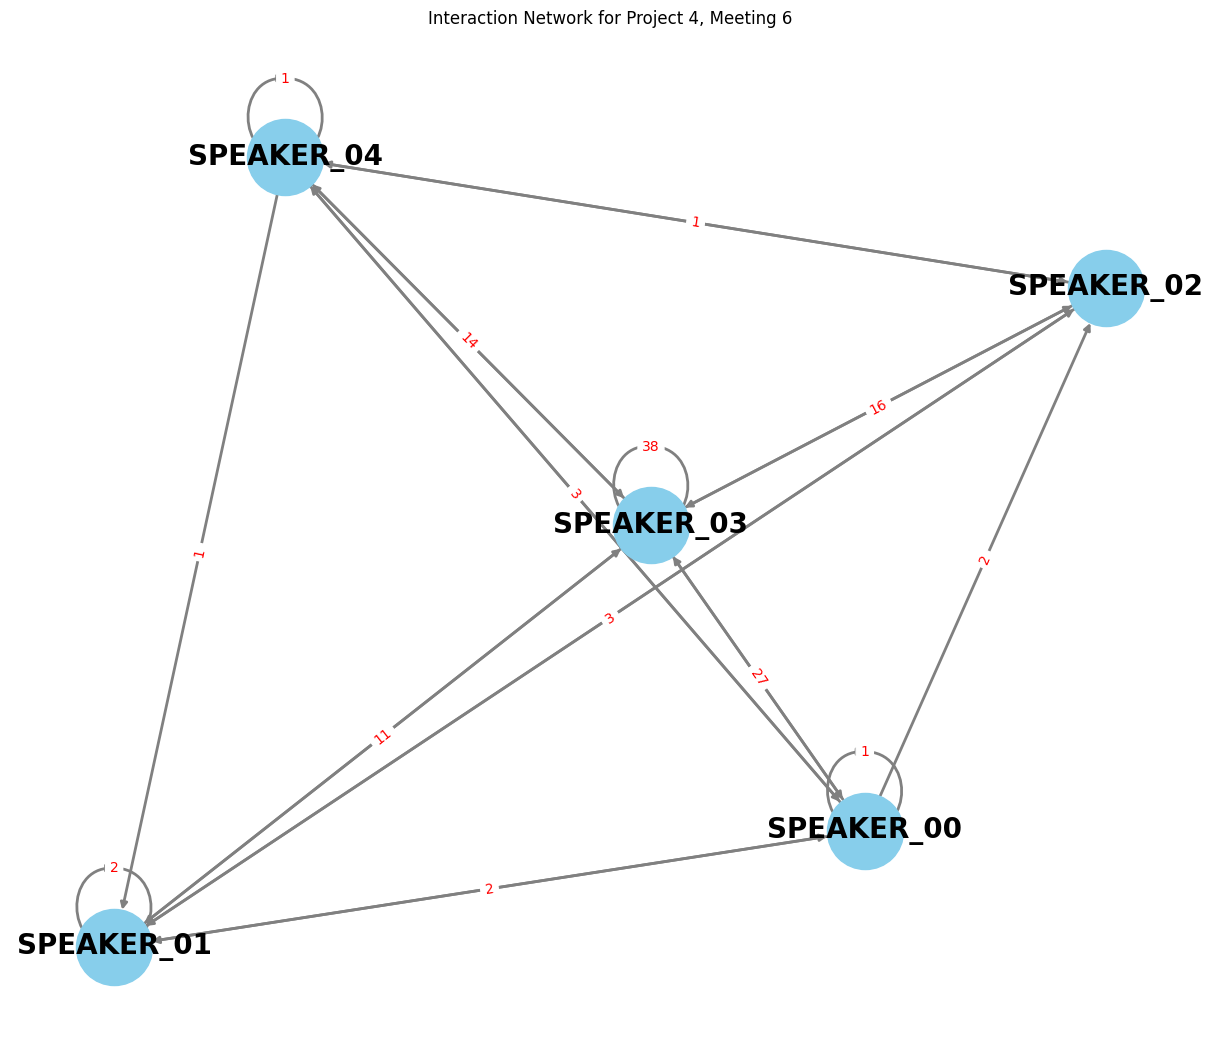

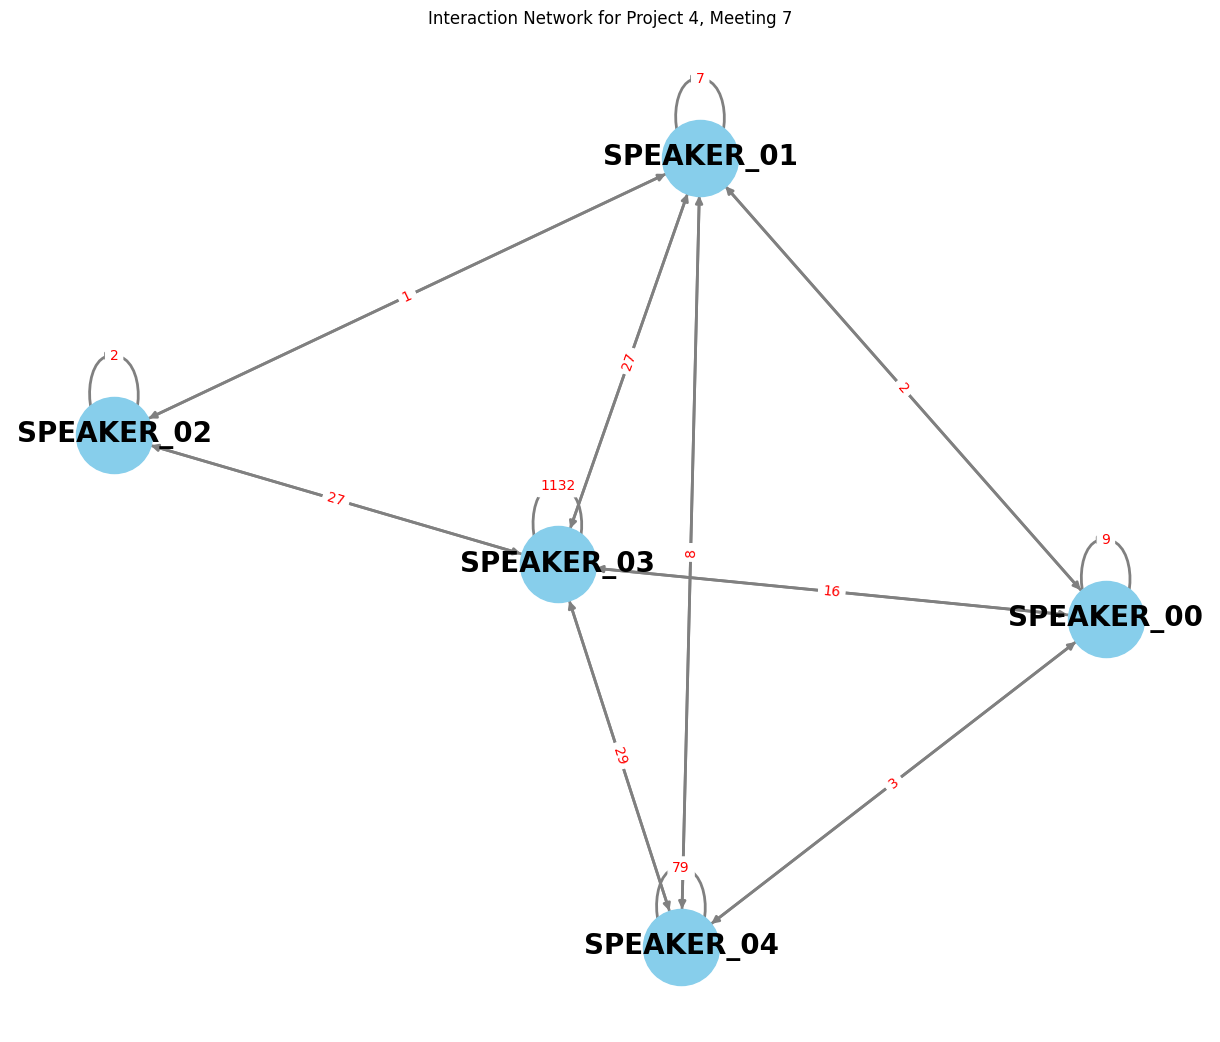

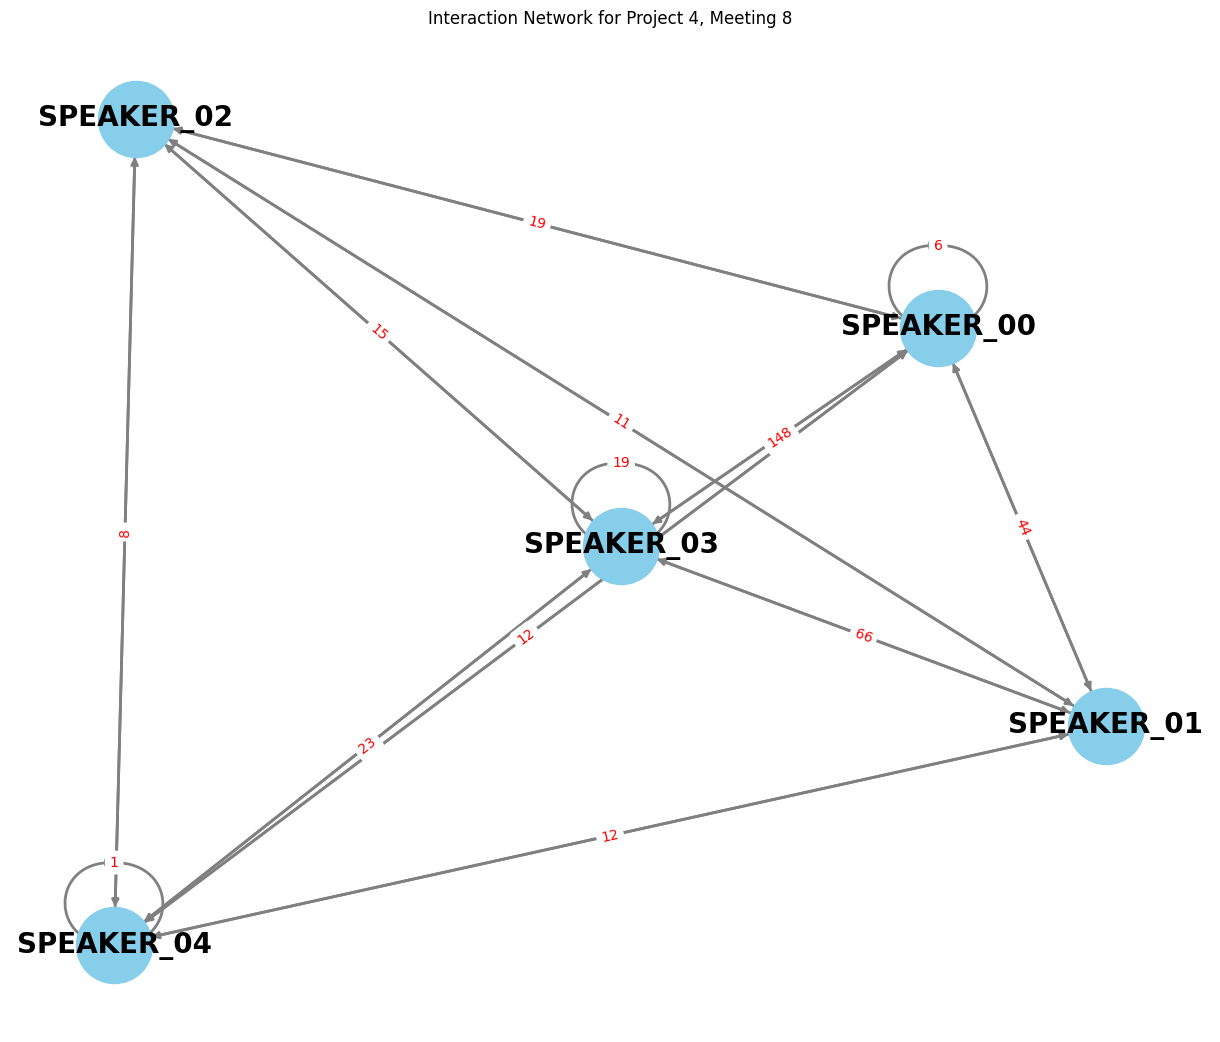

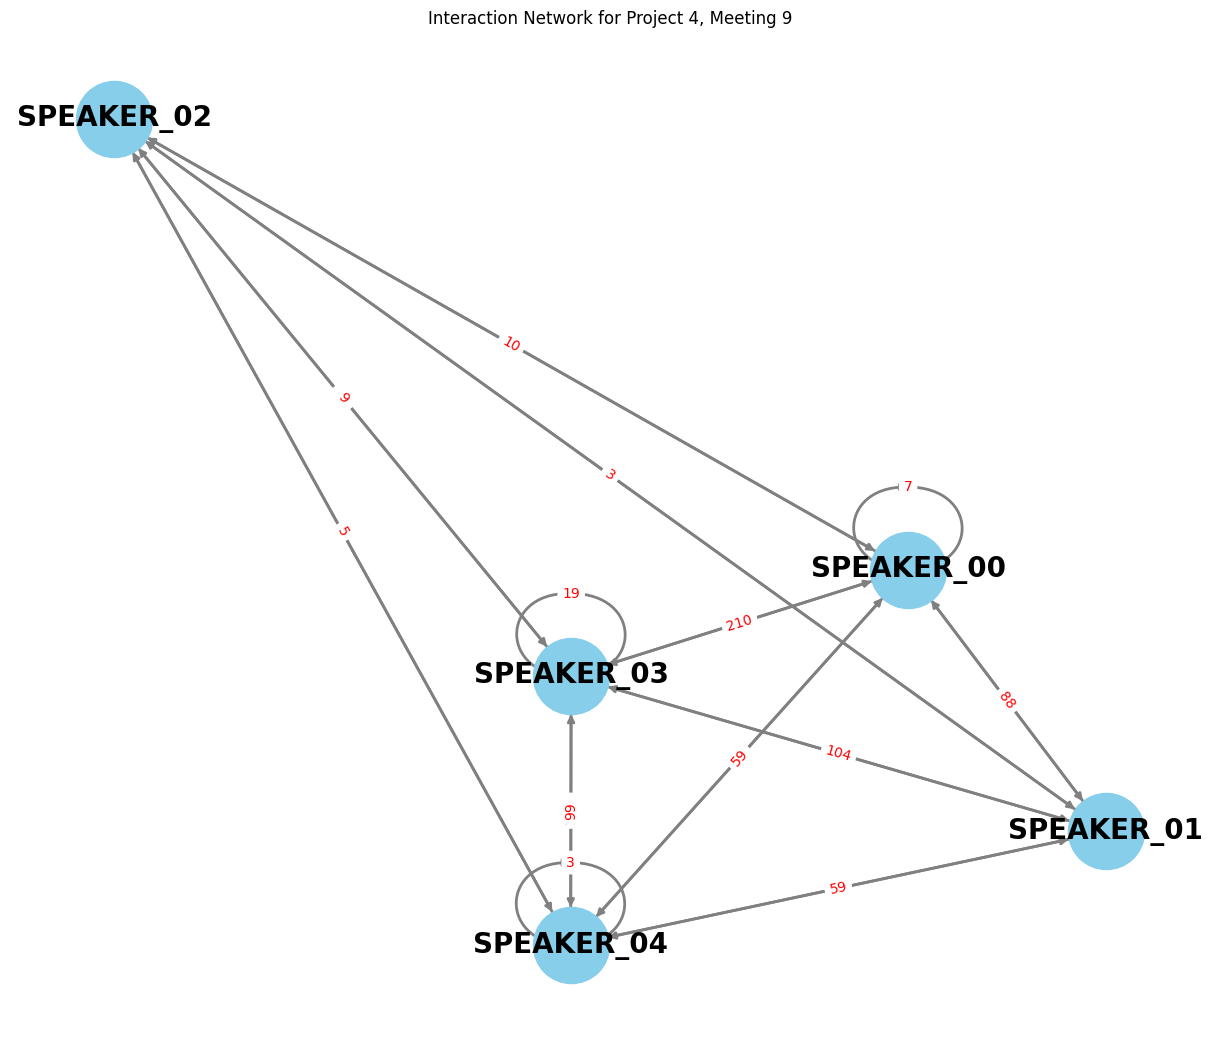

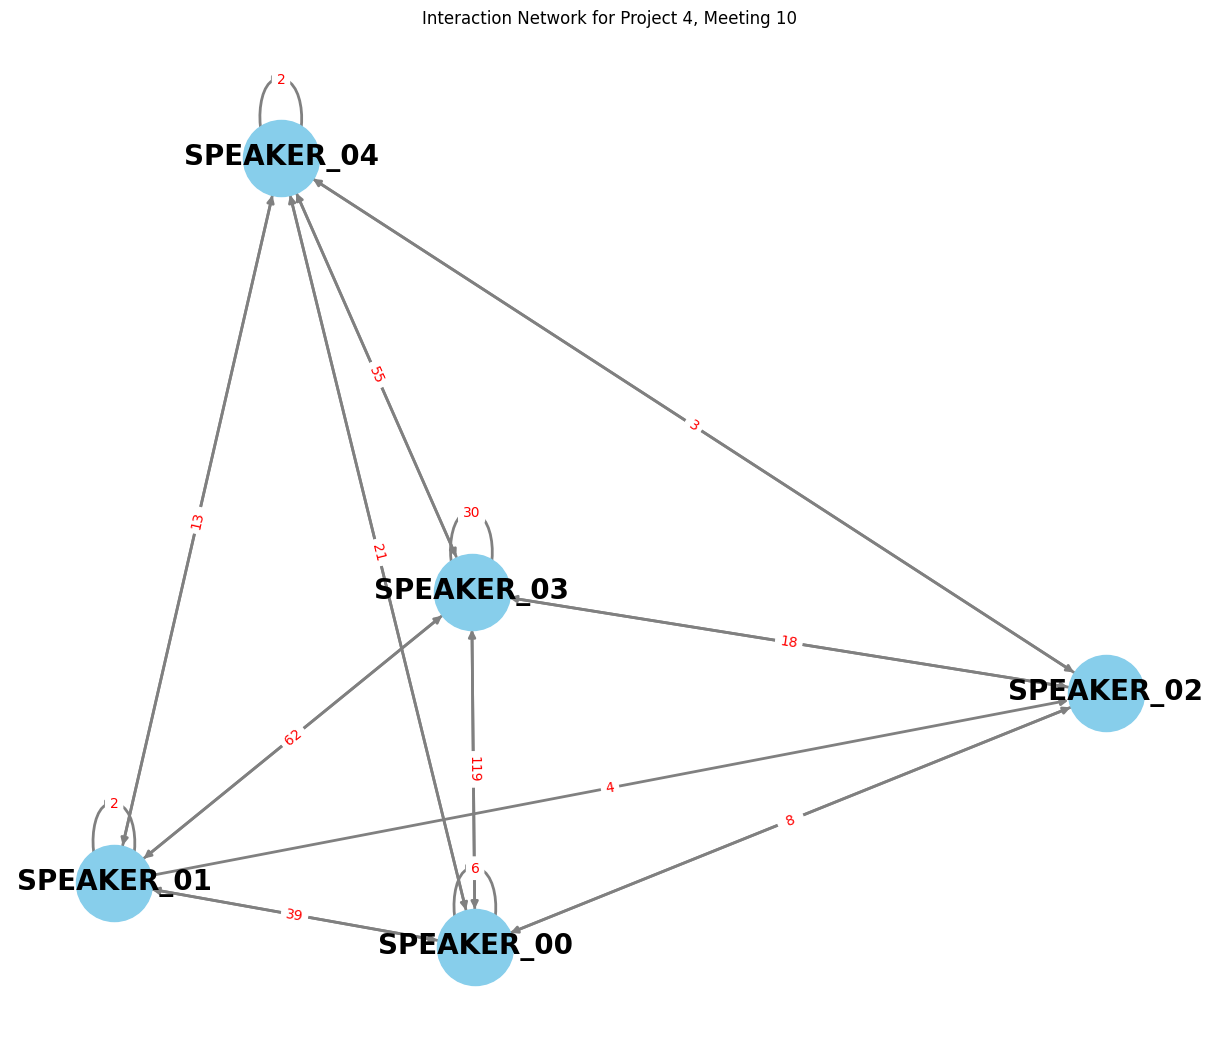

In [545]:
# Create graphs for each meeting
def create_interaction_graphs(dfs):
    graphs = []
    for df in dfs:
        G = nx.DiGraph()
        for i in range(len(df)):
            prev_speaker = df.iloc[i]['Speaker']
            if i < len(df) - 1:
                next_speaker = df.iloc[i+1]['Speaker']
            else:
                next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
            if df.iloc[i]['Text'].strip() != '':
                if G.has_edge(prev_speaker, next_speaker):
                    G[prev_speaker][next_speaker]['weight'] += 1
                else:
                    G.add_edge(prev_speaker, next_speaker, weight=1)
        graphs.append(G)
    return graphs

graphs_project3 = create_interaction_graphs(dfs_project3)
graphs_project4 = create_interaction_graphs(dfs_project4)

# Plotting Interaction Network Graph
def plot_interaction_network(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=20, font_color="black", font_weight="bold", width=2, edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

for i, G in enumerate(graphs_project3):
    plot_interaction_network(G, f'Interaction Network for Project 3, Meeting {i+1}')
for i, G in enumerate(graphs_project4):
    plot_interaction_network(G, f'Interaction Network for Project 4, Meeting {i+1}')